# Random Forest Analysis

This file is part of the reproduction package provided with the paper Understanding Dark Personality Traits and Strategic Choices in an Inspection Game.

This notebook contains the random forest model tuning, fit and analysis. 

Questions and correspondence should be addressed to Vinícius Ferraz (visferraz@gmail.com).

In [7]:
# Standard Libraries
import multiprocessing as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

# Machine Learning Libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    accuracy_score, auc, classification_report, confusion_matrix,
    f1_score, make_scorer, mean_absolute_error, mean_squared_error,
    precision_score, r2_score, recall_score, roc_auc_score, roc_curve
)
from sklearn.model_selection import (
    GroupKFold, KFold, StratifiedKFold,
    cross_val_score, cross_validate, train_test_split
)

# Imbalanced-Learn 
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN

# Hyperparameter Tuning 
import optuna

# Interpretability
import shap

%matplotlib inline

## Data Definitions

In [2]:
df_full_d = pd.read_csv('data/df_rep_p.csv')
df_os = pd.read_csv('data/df_os_p.csv')

In [3]:
df_f_p1 = df_full_d.loc[df_full_d['player_id']==1]
df_f_p2 = df_full_d.loc[df_full_d['player_id']==2]
df_os_p1 = df_os.loc[df_os['player_type']==1]
df_os_p2 = df_os.loc[df_os['player_type']==2]

In [4]:
# sets of variables for analysis 
dep = 's1' # y (binary action of choosing strategy 1)

# x one-shot
os_ind = ['D-factor','Age', 'Framing', 'Female','Dishonesty Score', 'STEM'] 

# x repeated game
full_ind = ['D-factor','Age', 'Framing', 'Female', 'STEM','Opponent S1 (t-1)', 'Own S1 Freq. (t-1)'] 

In [5]:
def split_dfs_cf(df, test_size, random_state):
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    return df_train, df_test

In [6]:
# splitting train-test dataframes
train_a, test_a = split_dfs_cf(df_full_d, 0.2, 42)
train_p1, test_p1 = split_dfs_cf(df_f_p1, 0.2, 42)
train_p2, test_p2 = split_dfs_cf(df_f_p2, 0.2, 42)
train_a_os, test_a_os = split_dfs_cf(df_os, 0.2, 42)
train_p1_os, test_p1_os = split_dfs_cf(df_os_p1, 0.2, 42)
train_p2_os, test_p2_os = split_dfs_cf(df_os_p2, 0.2, 42)

## Main Code

**Model Architecture: Hyperparameter Tuning**

The optimize_rf function optimizes hyperparameters for a Random Forest classifier using Optuna. It takes several input arguments like the training DataFrame, list of independent variables, dependent variable, number of trials, and resampler type (e.g., SMOTE or ADASYN). Depending on whether group-based K-fold is required, it either performs Group K-Fold or Stratified K-Fold for cross-validation. The function's primary objective is to maximize the ROC-AUC score.

In [8]:
def optimize_rf(df_train, independent_vars, dependent_var, participant_col=None, ntrials=100,
                use_groups=True, resampler_type=None):
    
    # Instantiate the resampler based on the resampler_type, if necessary 
    if resampler_type == 'adasyn':
        resampler = ADASYN(random_state=42)
    elif resampler_type == 'smote':
        resampler = SMOTE(random_state=42)
    elif resampler_type == 'none':
        resampler = None
    else:
        raise ValueError(f"Invalid resampler_type: {resampler_type}. Use 'adasyn', 'smote', or 'none'.")

    def objective(trial):
        n_estimators = trial.suggest_int('n_estimators', 500, 1500, step=100)
        max_depth = trial.suggest_int('max_depth', 5, 30, step=5)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 60, step=5)
        bootstrap = trial.suggest_categorical('bootstrap', [True, False])
        criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
        class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample'])
                         
        rf_clf = RandomForestClassifier(n_estimators=n_estimators, 
                                        max_depth=max_depth, 
                                        max_features=max_features, 
                                        min_samples_leaf=min_samples_leaf,
                                        bootstrap=bootstrap,
                                        criterion=criterion,
                                        class_weight=class_weight,
                                        random_state=42)

        if resampler:
            pipeline = Pipeline([(resampler_type, resampler), ('Random Forest Classifier', rf_clf)])
        else:
            pipeline = Pipeline([('Random Forest Classifier', rf_clf)])

        def custom_scorer(y_true, y_pred):
            return roc_auc_score(y_true, y_pred)

        scorer = make_scorer(custom_scorer, greater_is_better=True)

        auc_scores = []
        
        if use_groups:
            if participant_col is None:
                raise ValueError("participant_col must be provided when use_groups is True")
            
            gkf = GroupKFold(n_splits=5)
            for train_index, test_index in gkf.split(df_train[independent_vars],
                                                     groups=df_train[participant_col]):
                X_train_fold = df_train[independent_vars].values[train_index]
                X_test_fold = df_train[independent_vars].values[test_index]
                y_train_fold = df_train[dependent_var].values[train_index]
                y_test_fold = df_train[dependent_var].values[test_index]
                
                try:
                    pipeline.fit(X_train_fold, y_train_fold)
                    y_pred = pipeline.predict(X_test_fold)
                except Exception as e:
                    print(f"An error occurred: {e}")
                    raise optuna.TrialPruned()
                
                auc_scores.append(custom_scorer(y_test_fold, y_pred))
        
        else:
            kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            
            for train_index, test_index in kf.split(df_train[independent_vars], df_train[dependent_var]):
                X_train_fold = df_train[independent_vars].values[train_index]
                X_test_fold = df_train[independent_vars].values[test_index]
                y_train_fold = df_train[dependent_var].values[train_index]
                y_test_fold = df_train[dependent_var].values[test_index]
                
                try:
                    pipeline.fit(X_train_fold, y_train_fold)
                    y_pred = pipeline.predict(X_test_fold)
                except Exception as e:
                    print(f"An error occurred: {e}")
                    raise optuna.TrialPruned()

                auc_scores.append(custom_scorer(y_test_fold, y_pred))

        return np.mean(auc_scores)
    
    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(direction='maximize', sampler=sampler)
    study.optimize(objective, n_trials=ntrials, n_jobs=-1)

    best_params = study.best_params
    print(best_params)
    return best_params

**Model Fitting**

The function fit_random_forest takes the training and testing DataFrames, independent and dependent variables, and optimized parameters to fit a Random Forest model. It returns the fitted Random Forest model, predictions on the test set, and the pipeline used to fit the model.

In [9]:
def fit_random_forest(df_train, df_test, independent_vars, dependent_var,
                      best_params, resampler='none'):
    
    rf_clf = RandomForestClassifier(
        n_estimators = best_params['n_estimators'], 
        max_depth = best_params['max_depth'], 
        max_features = best_params['max_features'], 
        min_samples_leaf = best_params['min_samples_leaf'], 
        class_weight = best_params['class_weight'], 
        random_state = 42
    )
    
    if resampler == 'smote':
        sampler = SMOTE(random_state=42)
    elif resampler == 'adasyn':
        sampler = ADASYN(random_state=42)
    else:
        sampler = None
    
    if sampler:
        pipeline = Pipeline([('resampler', sampler), ('classifier', rf_clf)])
    else:
        pipeline = Pipeline([('classifier', rf_clf)])
        
    pipeline.fit(df_train[independent_vars], df_train[dependent_var].values.ravel())
    y_pred = pipeline.predict(df_test[independent_vars])

    return rf_clf, y_pred, pipeline

**Metrics**

calculate_metrics takes the test DataFrame, independent and dependent variables, and the trained Random Forest model to calculate various evaluation metrics. It returns a dictionary containing metrics such as Mean Squared Error, Mean Absolute Error, F1 score, Precision, Recall, and Confusion Matrix. calculate_roc_auc calculates the Receiver Operating Characteristic Area Under Curve (ROC-AUC) for the given Random Forest model. It returns the ROC-AUC score along with the False Positive Rate (FPR) and True Positive Rate (TPR).

In [10]:
def calculate_metrics(df_test, independent_vars, dependent_var, rf_model):
    metrics = {}
    y_test = df_test[dependent_var]
    y_pred = rf_model.predict(df_test[independent_vars])

    metrics['mse'] = mean_squared_error(y_test, y_pred)
    metrics['mae'] = mean_absolute_error(y_test, y_pred)
    metrics['rmse'] = mean_squared_error(y_test, y_pred, squared=False)

    scores = cross_val_score(rf_model, df_test[independent_vars], df_test[dependent_var], cv=5, 
                             scoring='neg_mean_squared_error')
    metrics['cv_rmse_scores'] = np.sqrt(-scores)
    
    y_pred_cat = y_pred > 0.5
    metrics['f1'] = f1_score(y_test > 0.5, y_pred_cat)
    metrics['precision'] = precision_score(y_test > 0.5, y_pred_cat)
    metrics['recall'] = recall_score(y_test > 0.5, y_pred_cat)
    metrics['confusion_mat'] = confusion_matrix(y_test > 0.5, y_pred_cat)
    metrics['accuracy'] = accuracy_score(y_test > 0.5, y_pred_cat)

    return metrics

def calculate_roc_auc(rf_model, df_test, independent_vars, dependent_var):
    y_test = df_test[dependent_var]
    y_pred_proba = rf_model.predict_proba(df_test[independent_vars])[:, 1]  
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    return roc_auc, fpr, tpr

**Plotting Functions**

These functions generate custom plot sets. plot_feature_importances takes a dictionary of training DataFrames, a list of independent variables, a dictionary of trained models, and a color code as input. It produces a subplot for each model to visualize feature importances in a horizontal bar char. plot_roc_curves takes a dictionary containing data required for plotting the ROC (Receiver Operating Characteristic) curves and a color code for the lines

In [11]:
def plot_feature_importances(df_trains_dict, independent_vars, models_dict, color):
    fig, axes = plt.subplots(1, len(models_dict), figsize=(12, 3), sharex=True)
    for ax, (model_name, model) in zip(axes, models_dict.items()):
        df_train = df_trains_dict[model_name]
        importances = model.feature_importances_
        indices = np.argsort(importances)[::1]
        ax.set_title(model_name)
        ax.barh(range(len(independent_vars)), importances[indices], color=color, edgecolor='grey', linewidth=0.5)
        ax.set_yticks(range(len(independent_vars)))
        ax.set_yticklabels(np.array(independent_vars)[indices])
    plt.tight_layout()

def plot_roc_curves(models_data, color):
    fig, axes = plt.subplots(1, len(models_data), figsize=(12, 3))
    for ax, (title, data) in zip(axes, models_data.items()):
        fpr, tpr, roc_auc = data
        ax.set_title(title)
        ax.plot(fpr, tpr, color=color, alpha=0.8, lw=1, label='RF (AUC = %0.3f)' % roc_auc)
        ax.plot([0, 1], [0, 1], color='dimgray', lw=1.2, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.0])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc="lower right")
    plt.tight_layout()

## Repeated Game

In [14]:
ntrials = 1000 # number of optimization trials

In [15]:
%%time
params_g = optimize_rf(train_a, full_ind, dep, participant_col="participant_code", ntrials=ntrials, use_groups=True, 
                       resampler_type='none')

[I 2023-09-09 17:46:45,770] A new study created in memory with name: no-name-f75fd4b4-79d6-470d-b377-703db71e9d17
[I 2023-09-09 17:51:37,106] Trial 0 finished with value: 0.7595940431223346 and parameters: {'n_estimators': 600, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 15, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.7595940431223346.
[I 2023-09-09 17:52:00,471] Trial 1 finished with value: 0.761213979744151 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.761213979744151.
[I 2023-09-09 17:52:41,801] Trial 3 finished with value: 0.7465471620810386 and parameters: {'n_estimators': 500, 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 35, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 1 with valu

[I 2023-09-09 18:09:10,662] Trial 21 finished with value: 0.7445152591643004 and parameters: {'n_estimators': 1400, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 5, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 26 with value: 0.7665943153552417.
[I 2023-09-09 18:09:40,004] Trial 29 finished with value: 0.7670202172704876 and parameters: {'n_estimators': 1300, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 29 with value: 0.7670202172704876.
[I 2023-09-09 18:10:25,461] Trial 25 finished with value: 0.7663981440953307 and parameters: {'n_estimators': 1100, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 29 with value: 0.7670202172704876.
[I 2023-09-09 18:13:58,463] Trial 30 finished with value: 0.7670696232138139 and parameters: {'

[I 2023-09-09 18:33:14,967] Trial 53 finished with value: 0.7662957538331835 and parameters: {'n_estimators': 1400, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 34 with value: 0.7675890994960415.
[I 2023-09-09 18:33:51,047] Trial 54 finished with value: 0.7661374711465657 and parameters: {'n_estimators': 1400, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 34 with value: 0.7675890994960415.
[I 2023-09-09 18:34:08,587] Trial 59 finished with value: 0.7665590185116686 and parameters: {'n_estimators': 1100, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 34 with value: 0.7675890994960415.
[I 2023-09-09 18:34:13,291] Trial 55 finished with value: 0.76613747114656

[I 2023-09-09 18:53:48,696] Trial 79 finished with value: 0.7608134953739685 and parameters: {'n_estimators': 1300, 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 50, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 34 with value: 0.7675890994960415.
[I 2023-09-09 18:53:54,273] Trial 81 finished with value: 0.7572090725563985 and parameters: {'n_estimators': 1300, 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 34 with value: 0.7675890994960415.
[I 2023-09-09 18:53:58,478] Trial 91 finished with value: 0.7623752637853395 and parameters: {'n_estimators': 1300, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 45, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 34 with value: 0.7675890994960415.
[I 2023-09-09 18:54:02,670] Trial 82 finished with value: 0.757209072556398

[I 2023-09-09 19:09:24,914] Trial 108 finished with value: 0.7670696232138139 and parameters: {'n_estimators': 1200, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 34 with value: 0.7675890994960415.
[I 2023-09-09 19:09:31,902] Trial 109 finished with value: 0.7670696232138139 and parameters: {'n_estimators': 1200, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 34 with value: 0.7675890994960415.
[I 2023-09-09 19:10:04,996] Trial 110 finished with value: 0.7670696232138139 and parameters: {'n_estimators': 1200, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 34 with value: 0.7675890994960415.
[I 2023-09-09 19:14:32,405] Trial 111 finished with value: 0.767069623

[I 2023-09-09 19:26:09,027] Trial 139 finished with value: 0.7662680725767306 and parameters: {'n_estimators': 1100, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 55, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 34 with value: 0.7675890994960415.
[I 2023-09-09 19:26:34,458] Trial 129 finished with value: 0.7667749459096908 and parameters: {'n_estimators': 1100, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 55, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 34 with value: 0.7675890994960415.
[I 2023-09-09 19:27:11,663] Trial 130 finished with value: 0.7667749459096908 and parameters: {'n_estimators': 1100, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 55, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 34 with value: 0.7675890994960415.
[I 2023-09-09 19:27:24,886] Trial 131 finished with value: 0.7667749459096908 and p

[I 2023-09-09 19:39:40,565] Trial 163 finished with value: 0.7664838329399691 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 34 with value: 0.7675890994960415.
[I 2023-09-09 19:39:41,492] Trial 162 finished with value: 0.7664838329399691 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 34 with value: 0.7675890994960415.
[I 2023-09-09 19:39:43,796] Trial 159 finished with value: 0.767506028685198 and parameters: {'n_estimators': 1100, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 34 with value: 0.7675890994960415.
[I 2023-09-09 19:39:58,305] Trial 164 finished with value: 0.7664838329399

[I 2023-09-09 19:50:07,826] Trial 189 finished with value: 0.767506028685198 and parameters: {'n_estimators': 1100, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 34 with value: 0.7675890994960415.
[I 2023-09-09 19:50:10,614] Trial 190 finished with value: 0.767506028685198 and parameters: {'n_estimators': 1100, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 34 with value: 0.7675890994960415.
[I 2023-09-09 19:55:01,506] Trial 191 finished with value: 0.767506028685198 and parameters: {'n_estimators': 1100, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 34 with value: 0.7675890994960415.
[I 2023-09-09 19:57:22,831] Trial 192 finished with value: 0.767506028685198

[I 2023-09-09 20:17:13,473] Trial 216 finished with value: 0.7660559454686424 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 35, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 34 with value: 0.7675890994960415.
[I 2023-09-09 20:17:19,129] Trial 217 finished with value: 0.7675890994960415 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 34 with value: 0.7675890994960415.
[I 2023-09-09 20:17:48,532] Trial 219 finished with value: 0.7675890994960415 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 34 with value: 0.7675890994960415.
[I 2023-09-09 20:18:12,527] Trial 220 finished with value: 0.764524237376

[I 2023-09-09 20:40:42,446] Trial 243 finished with value: 0.7675890994960415 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 34 with value: 0.7675890994960415.
[I 2023-09-09 20:41:22,208] Trial 244 finished with value: 0.7675890994960415 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 34 with value: 0.7675890994960415.
[I 2023-09-09 20:42:18,797] Trial 245 finished with value: 0.7675890994960415 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 34 with value: 0.7675890994960415.
[I 2023-09-09 20:42:39,658] Trial 246 finished with value: 0.767589099496

[I 2023-09-09 21:01:06,251] Trial 270 finished with value: 0.7675890994960415 and parameters: {'n_estimators': 1300, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 34 with value: 0.7675890994960415.
[I 2023-09-09 21:04:46,182] Trial 271 finished with value: 0.7675890994960415 and parameters: {'n_estimators': 1300, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 34 with value: 0.7675890994960415.
[I 2023-09-09 21:06:37,909] Trial 272 finished with value: 0.7663846299715918 and parameters: {'n_estimators': 1300, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 55, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 34 with value: 0.7675890994960415.
[I 2023-09-09 21:06:37,957] Trial 274 finished with value: 0.766905154243

[I 2023-09-09 21:25:06,467] Trial 297 finished with value: 0.7675904949396306 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 293 with value: 0.7675904949396306.
[I 2023-09-09 21:25:17,346] Trial 298 finished with value: 0.7675904949396306 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 293 with value: 0.7675904949396306.
[I 2023-09-09 21:25:28,093] Trial 299 finished with value: 0.7675904949396306 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 293 with value: 0.7675904949396306.
[I 2023-09-09 21:25:35,552] Trial 300 finished with value: 0.

[I 2023-09-09 21:40:22,310] Trial 321 finished with value: 0.7652858885123521 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 293 with value: 0.7675904949396306.
[I 2023-09-09 21:43:08,696] Trial 329 finished with value: 0.7675904949396306 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 293 with value: 0.7675904949396306.
[I 2023-09-09 21:44:45,614] Trial 325 finished with value: 0.7652858885123521 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 293 with value: 0.7675904949396306.
[I 2023-09-09 21:44:48,652] Trial 339 finished with value: 0.7659

[I 2023-09-09 21:57:46,044] Trial 354 finished with value: 0.7675904949396306 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 293 with value: 0.7675904949396306.
[I 2023-09-09 21:58:04,969] Trial 355 finished with value: 0.7675904949396306 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 293 with value: 0.7675904949396306.
[I 2023-09-09 21:58:45,474] Trial 346 finished with value: 0.7638256780564519 and parameters: {'n_estimators': 1500, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 15, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 293 with value: 0.7675904949396306.
[I 2023-09-09 21:58:45,893] Trial 347 finished with value: 0.

[I 2023-09-09 22:23:27,820] Trial 376 finished with value: 0.7675904949396306 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 293 with value: 0.7675904949396306.
[I 2023-09-09 22:23:42,202] Trial 377 finished with value: 0.7675904949396306 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 293 with value: 0.7675904949396306.
[I 2023-09-09 22:23:50,053] Trial 386 finished with value: 0.7663404215127059 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 293 with value: 0.7675904949396306.
[I 2023-09-09 22:24:02,725] Trial 378 finished with value: 0.7

[I 2023-09-09 22:47:44,127] Trial 405 finished with value: 0.7674740088984262 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 55, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 293 with value: 0.7675904949396306.
[I 2023-09-09 22:51:23,552] Trial 407 finished with value: 0.7673395136594374 and parameters: {'n_estimators': 1300, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 293 with value: 0.7675904949396306.
[I 2023-09-09 22:51:32,689] Trial 406 finished with value: 0.7670054085959355 and parameters: {'n_estimators': 1400, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 55, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 293 with value: 0.7675904949396306.
[I 2023-09-09 22:51:37,609] Trial 408 finished with value: 0.

[I 2023-09-09 23:07:33,827] Trial 432 finished with value: 0.7675904949396306 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 293 with value: 0.7675904949396306.
[I 2023-09-09 23:08:08,085] Trial 433 finished with value: 0.7675904949396306 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 293 with value: 0.7675904949396306.
[I 2023-09-09 23:08:25,509] Trial 436 finished with value: 0.762796810706061 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 293 with value: 0.7675904949396306.
[I 2023-09-09 23:08:27,887] Trial 434 finished with value: 0.

[I 2023-09-09 23:28:28,003] Trial 465 finished with value: 0.7673570049138102 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 293 with value: 0.7675904949396306.
[I 2023-09-09 23:28:30,603] Trial 456 finished with value: 0.7675904949396306 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 293 with value: 0.7675904949396306.
[I 2023-09-09 23:28:47,738] Trial 457 finished with value: 0.7675904949396306 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 293 with value: 0.7675904949396306.
[I 2023-09-09 23:29:11,484] Trial 458 finished with value: 0.7675904949

[I 2023-09-09 23:48:59,332] Trial 486 finished with value: 0.7672290699522829 and parameters: {'n_estimators': 1100, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 293 with value: 0.7675904949396306.
[I 2023-09-09 23:51:00,618] Trial 487 finished with value: 0.7672290699522829 and parameters: {'n_estimators': 1100, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 293 with value: 0.7675904949396306.
[I 2023-09-09 23:51:08,333] Trial 488 finished with value: 0.7669422201456803 and parameters: {'n_estimators': 1100, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 293 with value: 0.7675904949396306.
[I 2023-09-09 23:51:14,768] Trial 490 finished with value: 0.

[I 2023-09-10 00:05:44,849] Trial 513 finished with value: 0.765652642655443 and parameters: {'n_estimators': 1200, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 45, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 00:07:02,982] Trial 515 finished with value: 0.767564047846944 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 45, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 00:07:11,894] Trial 514 finished with value: 0.7670595181345916 and parameters: {'n_estimators': 1200, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 00:07:21,249] Trial 516 finished with value: 0.

[I 2023-09-10 00:23:11,672] Trial 540 finished with value: 0.7673570049138102 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 00:24:08,075] Trial 534 finished with value: 0.7677620836514275 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 00:25:15,868] Trial 544 finished with value: 0.7664105075355179 and parameters: {'n_estimators': 1300, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 00:25:16,128] Trial 542 finished with value: 0.765136644681086 and 

[I 2023-09-10 00:51:13,625] Trial 571 finished with value: 0.7677620836514275 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 00:52:30,620] Trial 568 finished with value: 0.7641202107539719 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 00:52:33,044] Trial 566 finished with value: 0.7638594854824281 and parameters: {'n_estimators': 1200, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 00:52:54,733] Trial 567 finished with value: 0.763

[I 2023-09-10 01:14:30,225] Trial 594 finished with value: 0.7677620836514275 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 01:14:58,360] Trial 595 finished with value: 0.7677620836514275 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 01:15:31,861] Trial 596 finished with value: 0.7677620836514275 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 01:16:24,646] Trial 597 finished with value: 0.

[I 2023-09-10 01:36:07,309] Trial 621 finished with value: 0.767564047846944 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 45, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 01:36:34,913] Trial 622 finished with value: 0.767564047846944 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 45, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 01:37:45,488] Trial 627 finished with value: 0.7667583833937878 and parameters: {'n_estimators': 1100, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 45, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 01:38:04,845] Trial 623 finished with value: 0.76

[I 2023-09-10 01:58:01,924] Trial 646 finished with value: 0.7644627524804107 and parameters: {'n_estimators': 1200, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 35, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 01:58:45,953] Trial 649 finished with value: 0.7644627524804107 and parameters: {'n_estimators': 1200, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 35, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 02:00:27,945] Trial 650 finished with value: 0.7656003182832191 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 35, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 02:01:51,682] Trial 651 finished with value: 

[I 2023-09-10 02:18:57,301] Trial 675 finished with value: 0.7677620836514275 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 02:18:57,748] Trial 677 finished with value: 0.7663448526907015 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 02:19:12,078] Trial 676 finished with value: 0.7677620836514275 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 02:24:26,546] Trial 678 finished with value: 0.7

[I 2023-09-10 02:42:06,988] Trial 698 finished with value: 0.7671001627079318 and parameters: {'n_estimators': 1300, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 02:43:21,543] Trial 699 finished with value: 0.7671001627079318 and parameters: {'n_estimators': 1300, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 02:43:35,186] Trial 709 finished with value: 0.7667102015841953 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 02:44:09,212] Trial 700 finished with value: 0.7671001627

[I 2023-09-10 03:05:29,270] Trial 729 finished with value: 0.7677620836514275 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 03:05:31,978] Trial 730 finished with value: 0.7677620836514275 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 03:05:40,831] Trial 731 finished with value: 0.7677620836514275 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 03:06:03,338] Trial 732 finished with value: 0.

[I 2023-09-10 03:20:38,098] Trial 756 finished with value: 0.7656003182832191 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 35, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 03:23:11,887] Trial 757 finished with value: 0.7656003182832191 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 35, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 03:23:40,285] Trial 758 finished with value: 0.7656003182832191 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 35, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 03:25:58,728] Trial 759 finished with value: 0.

[I 2023-09-10 03:42:33,358] Trial 782 finished with value: 0.7669422201456803 and parameters: {'n_estimators': 1100, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 03:42:39,731] Trial 783 finished with value: 0.7669422201456803 and parameters: {'n_estimators': 1100, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 03:43:21,906] Trial 784 finished with value: 0.7669422201456803 and parameters: {'n_estimators': 1100, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 03:43:50,989] Trial 785 finished with value: 0.

[I 2023-09-10 04:04:19,093] Trial 809 finished with value: 0.7641202107539719 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 04:04:30,603] Trial 810 finished with value: 0.7641202107539719 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 04:04:42,086] Trial 811 finished with value: 0.7641202107539719 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 04:05:59,389] Trial 815 finished with value: 0.767762

[I 2023-09-10 04:19:26,471] Trial 834 finished with value: 0.7671001627079318 and parameters: {'n_estimators': 1300, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 04:19:47,980] Trial 843 finished with value: 0.7664105075355179 and parameters: {'n_estimators': 1300, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 04:21:28,229] Trial 838 finished with value: 0.7671001627079318 and parameters: {'n_estimators': 1300, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 04:21:30,169] Trial 844 finished with value: 0.7664105075

[I 2023-09-10 04:39:46,000] Trial 864 finished with value: 0.767564047846944 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 45, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 04:40:22,160] Trial 865 finished with value: 0.7656003182832191 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 35, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 04:41:09,253] Trial 866 finished with value: 0.7656003182832191 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 35, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 04:41:33,465] Trial 867 finished with value: 0.7

[I 2023-09-10 05:03:49,433] Trial 891 finished with value: 0.7677620836514275 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 05:03:58,163] Trial 892 finished with value: 0.7677620836514275 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 05:05:20,097] Trial 893 finished with value: 0.7677620836514275 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 05:06:14,773] Trial 894 finished with value: 0.

[I 2023-09-10 05:25:43,744] Trial 918 finished with value: 0.7669422201456803 and parameters: {'n_estimators': 1100, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 05:27:06,585] Trial 919 finished with value: 0.7669422201456803 and parameters: {'n_estimators': 1100, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 05:29:31,026] Trial 920 finished with value: 0.7669422201456803 and parameters: {'n_estimators': 1100, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 05:29:36,616] Trial 922 finished with value: 0.

[I 2023-09-10 05:49:54,509] Trial 945 finished with value: 0.7677620836514275 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 05:50:00,822] Trial 946 finished with value: 0.7630546953853589 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 05:50:17,860] Trial 947 finished with value: 0.7677620836514275 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 05:51:48,981] Trial 948 finished with value: 0.

[I 2023-09-10 06:14:51,526] Trial 972 finished with value: 0.767564047846944 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 45, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 06:15:06,014] Trial 974 finished with value: 0.767564047846944 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 45, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 06:15:06,492] Trial 973 finished with value: 0.767564047846944 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 45, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 496 with value: 0.7677620836514275.
[I 2023-09-10 06:16:18,937] Trial 975 finished with value: 0.767

[I 2023-09-10 06:23:25,350] Trial 999 finished with value: 0.7667102015841953 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 496 with value: 0.7677620836514275.


{'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}
CPU times: user 14h 13min 34s, sys: 2h 8min 17s, total: 16h 21min 51s
Wall time: 12h 36min 39s


In [16]:
%%time
params_p1 = optimize_rf(train_p1, full_ind, dep, participant_col="participant_code", ntrials=ntrials, use_groups=True, 
                       resampler_type='none')

[I 2023-09-10 06:23:25,392] A new study created in memory with name: no-name-fb0474c4-4606-4f86-bb92-cdbacfa94c01
[I 2023-09-10 06:26:05,443] Trial 4 finished with value: 0.7534737464466488 and parameters: {'n_estimators': 500, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 4 with value: 0.7534737464466488.
[I 2023-09-10 06:26:53,088] Trial 11 finished with value: 0.7475188103685695 and parameters: {'n_estimators': 600, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 4 with value: 0.7534737464466488.
[I 2023-09-10 06:27:16,338] Trial 12 finished with value: 0.7461343099023757 and parameters: {'n_estimators': 700, 'max_depth': 25, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 4 with value: 0.7534737

[I 2023-09-10 06:38:07,128] Trial 29 finished with value: 0.7618515909672017 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 29 with value: 0.7618515909672017.
[I 2023-09-10 06:38:08,221] Trial 21 finished with value: 0.7099928406296793 and parameters: {'n_estimators': 900, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 5, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 29 with value: 0.7618515909672017.
[I 2023-09-10 06:38:12,049] Trial 26 finished with value: 0.7468949717388143 and parameters: {'n_estimators': 1100, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 5, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 29 with value: 0.7618515909672017.
[I 2023-09-10 06:38:31,709] Trial 30 finished with value: 0.7582903181298974 and parameters: {'n_estimators'

[I 2023-09-10 06:46:19,965] Trial 54 finished with value: 0.7618515909672017 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 29 with value: 0.7618515909672017.
[I 2023-09-10 06:46:29,195] Trial 56 finished with value: 0.7576587185833211 and parameters: {'n_estimators': 700, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 29 with value: 0.7618515909672017.
[I 2023-09-10 06:46:54,550] Trial 57 finished with value: 0.7576587185833211 and parameters: {'n_estimators': 700, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 29 with value: 0.7618515909672017.
[I 2023-09-10 06:47:57,797] Trial 55 finished with value: 0.7618515909672017 and parameter

[I 2023-09-10 06:56:53,923] Trial 79 finished with value: 0.7627316703864827 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 72 with value: 0.7631500804283238.
[I 2023-09-10 06:57:19,299] Trial 84 finished with value: 0.7413972937618617 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 15, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 72 with value: 0.7631500804283238.
[I 2023-09-10 06:57:28,971] Trial 80 finished with value: 0.7627316703864827 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 72 with value: 0.7631500804283238.
[I 2023-09-10 06:57:31,246] Trial 85 finished with value: 0.7433302160210828 and parameters: {'n_esti

[I 2023-09-10 07:11:43,077] Trial 109 finished with value: 0.7631074390020938 and parameters: {'n_estimators': 1300, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 15, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 100 with value: 0.7632493801355318.
[I 2023-09-10 07:11:53,847] Trial 110 finished with value: 0.7631074390020938 and parameters: {'n_estimators': 1300, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 15, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 100 with value: 0.7632493801355318.
[I 2023-09-10 07:11:55,616] Trial 111 finished with value: 0.7631074390020938 and parameters: {'n_estimators': 1300, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 15, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 100 with value: 0.7632493801355318.
[I 2023-09-10 07:12:03,566] Trial 112 finished with value: 0.7631074390020938 and parameters: {'n

[I 2023-09-10 07:22:42,912] Trial 136 finished with value: 0.7600523984793722 and parameters: {'n_estimators': 1400, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 20, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 140 with value: 0.7635080132580675.
[I 2023-09-10 07:23:48,493] Trial 138 finished with value: 0.7634863561470122 and parameters: {'n_estimators': 1100, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 20, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 140 with value: 0.7635080132580675.
[I 2023-09-10 07:24:12,008] Trial 143 finished with value: 0.7635080132580675 and parameters: {'n_estimators': 600, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 20, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 140 with value: 0.7635080132580675.
[I 2023-09-10 07:25:20,747] Trial 139 finished with value: 0.7634863561470122 and parameters: {'n

[I 2023-09-10 07:36:11,289] Trial 163 finished with value: 0.7498112566669697 and parameters: {'n_estimators': 1100, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 25, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 140 with value: 0.7635080132580675.
[I 2023-09-10 07:36:22,616] Trial 171 finished with value: 0.7416875483399636 and parameters: {'n_estimators': 1100, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 25, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 140 with value: 0.7635080132580675.
[I 2023-09-10 07:36:41,856] Trial 164 finished with value: 0.7498112566669697 and parameters: {'n_estimators': 1100, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 25, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 140 with value: 0.7635080132580675.
[I 2023-09-10 07:37:05,102] Trial 166 finished with value: 0.7498112566669697 and parameters: {

[I 2023-09-10 07:47:38,822] Trial 197 finished with value: 0.7635080132580675 and parameters: {'n_estimators': 600, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 20, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 140 with value: 0.7635080132580675.
[I 2023-09-10 07:47:44,500] Trial 191 finished with value: 0.7634863561470122 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 20, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 140 with value: 0.7635080132580675.
[I 2023-09-10 07:47:55,883] Trial 190 finished with value: 0.7618327765165911 and parameters: {'n_estimators': 1000, 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 20, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 140 with value: 0.7635080132580675.
[I 2023-09-10 07:48:43,989] Trial 199 finished with value: 0.7635080132580675 and parameters: {'n

[I 2023-09-10 07:54:50,618] Trial 221 finished with value: 0.7635080132580675 and parameters: {'n_estimators': 600, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 20, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 140 with value: 0.7635080132580675.
[I 2023-09-10 07:55:31,961] Trial 222 finished with value: 0.7490049298955711 and parameters: {'n_estimators': 600, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 35, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 140 with value: 0.7635080132580675.
[I 2023-09-10 07:55:40,491] Trial 223 finished with value: 0.7635080132580675 and parameters: {'n_estimators': 600, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 20, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 140 with value: 0.7635080132580675.
[I 2023-09-10 07:55:50,326] Trial 224 finished with value: 0.7635080132580675 and parameters: {'n_es

[I 2023-09-10 08:01:12,921] Trial 249 finished with value: 0.7637107212286488 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 20, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 235 with value: 0.7637107212286488.
[I 2023-09-10 08:01:13,341] Trial 250 finished with value: 0.7637107212286488 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 20, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 235 with value: 0.7637107212286488.
[I 2023-09-10 08:01:23,633] Trial 251 finished with value: 0.7637107212286488 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 20, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 235 with value: 0.7637107212286488.
[I 2023-09-10 08:02:06,491] Trial 252 finished with value: 0.7637107212286488 and parameters: {'n_es

[I 2023-09-10 08:07:59,073] Trial 277 finished with value: 0.7634791862139897 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 15, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 235 with value: 0.7637107212286488.
[I 2023-09-10 08:08:02,013] Trial 279 finished with value: 0.7634791862139897 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 15, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 235 with value: 0.7637107212286488.
[I 2023-09-10 08:08:03,790] Trial 278 finished with value: 0.7634791862139897 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 15, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 235 with value: 0.7637107212286488.
[I 2023-09-10 08:08:07,930] Trial 281 finished with value: 0.7481861061511861 and parameters: {'n_es

[I 2023-09-10 08:13:33,367] Trial 302 finished with value: 0.7510937357915932 and parameters: {'n_estimators': 500, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 25, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 235 with value: 0.7637107212286488.
[I 2023-09-10 08:13:35,268] Trial 305 finished with value: 0.7499949508208443 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 25, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 235 with value: 0.7637107212286488.
[I 2023-09-10 08:14:03,062] Trial 307 finished with value: 0.7526612674929642 and parameters: {'n_estimators': 500, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 25, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 235 with value: 0.7637107212286488.
[I 2023-09-10 08:15:05,730] Trial 309 finished with value: 0.7642787593188015 and parameters: {'n_est

[I 2023-09-10 08:22:07,772] Trial 333 finished with value: 0.7635734080538716 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 20, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 309 with value: 0.7642787593188015.
[I 2023-09-10 08:22:15,596] Trial 336 finished with value: 0.7642787593188015 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 20, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 309 with value: 0.7642787593188015.
[I 2023-09-10 08:22:27,982] Trial 334 finished with value: 0.7635734080538716 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 20, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 309 with value: 0.7642787593188015.
[I 2023-09-10 08:22:47,400] Trial 335 finished with value: 0.7635734080538716 and paramet

[I 2023-09-10 08:25:32,924] Trial 359 finished with value: 0.7635706197195028 and parameters: {'n_estimators': 500, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 20, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 309 with value: 0.7642787593188015.
[I 2023-09-10 08:25:36,436] Trial 361 finished with value: 0.7635734080538716 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 20, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 309 with value: 0.7642787593188015.
[I 2023-09-10 08:25:37,227] Trial 364 finished with value: 0.7582903181298974 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 20, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 309 with value: 0.7642787593188015.
[I 2023-09-10 08:25:37,842] Trial 363 finished with value: 0.7582903181298974

[I 2023-09-10 08:28:09,982] Trial 388 finished with value: 0.7509878977156503 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 30, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 379 with value: 0.7645648104369618.
[I 2023-09-10 08:28:13,837] Trial 390 finished with value: 0.7645648104369618 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 15, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 379 with value: 0.7645648104369618.
[I 2023-09-10 08:28:20,595] Trial 391 finished with value: 0.7645648104369618 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 15, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 379 with value: 0.7645648104369618.
[I 2023-09-10 08:28:22,674] Trial 392 finished with value: 0.7645648104369618 and parameters: {'n_estimators'

[I 2023-09-10 08:30:32,592] Trial 419 finished with value: 0.7645648104369618 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 15, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 379 with value: 0.7645648104369618.
[I 2023-09-10 08:30:36,602] Trial 420 finished with value: 0.7645648104369618 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 15, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 379 with value: 0.7645648104369618.
[I 2023-09-10 08:30:37,258] Trial 421 finished with value: 0.7645648104369618 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 15, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 379 with value: 0.7645648104369618.
[I 2023-09-10 08:30:42,540] Trial 422 finished with value: 0.7645648104369618 and parameters: {'n_estimators'

[I 2023-09-10 08:33:15,282] Trial 443 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 08:33:18,185] Trial 444 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 08:33:21,202] Trial 445 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 08:33:22,183] Trial 446 finished with value: 0.7645648104369618 and parameters: {'n_estimators'

[I 2023-09-10 08:37:52,117] Trial 460 finished with value: 0.7530421040597097 and parameters: {'n_estimators': 800, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 08:38:05,526] Trial 470 finished with value: 0.7534316602431865 and parameters: {'n_estimators': 500, 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 08:39:16,278] Trial 474 finished with value: 0.7534316602431865 and parameters: {'n_estimators': 500, 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 08:39:22,860] Trial 475 finished with value: 0.7534316602431865 and parameters: {'n_estimato

[I 2023-09-10 08:44:37,064] Trial 500 finished with value: 0.7580398498743988 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 08:44:40,604] Trial 497 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 08:44:52,925] Trial 501 finished with value: 0.7467323201443341 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 08:45:01,865] Trial 502 finished with value: 0.7580398498743988 and parameters: {'n_estimato

[I 2023-09-10 08:51:01,723] Trial 527 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 08:51:04,643] Trial 529 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 08:51:05,600] Trial 528 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 08:51:10,697] Trial 530 finished with value: 0.7648452784795137 and parameters: {'n_estimators'

[I 2023-09-10 08:57:32,824] Trial 556 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 08:58:05,850] Trial 557 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 08:58:12,922] Trial 558 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 08:58:21,149] Trial 559 finished with value: 0.7648452784795137 and parameters: {'n_estimators'

[I 2023-09-10 09:04:01,030] Trial 580 finished with value: 0.7641399272145838 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 09:04:33,832] Trial 584 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 09:04:40,598] Trial 585 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 09:04:50,972] Trial 586 finished with value: 0.7648452784795137 and parameters: {'n_estimators'

[I 2023-09-10 09:10:43,143] Trial 604 finished with value: 0.7628598744655102 and parameters: {'n_estimators': 600, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 5, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 09:11:13,878] Trial 612 finished with value: 0.7632474560646619 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 5, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 09:11:39,372] Trial 613 finished with value: 0.7632474560646619 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 5, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 09:11:55,055] Trial 614 finished with value: 0.7632474560646619 and parameters: {'n_estimators': 5

[I 2023-09-10 09:17:27,701] Trial 639 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 09:17:32,219] Trial 641 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 09:17:41,140] Trial 642 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 09:17:49,276] Trial 643 finished with value: 0.7648452784795137 and parameters: {'n_estimators'

[I 2023-09-10 09:23:48,024] Trial 668 finished with value: 0.7380786771022331 and parameters: {'n_estimators': 500, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 09:23:50,750] Trial 666 finished with value: 0.7618515909672017 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 09:24:19,046] Trial 669 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 09:24:24,785] Trial 672 finished with value: 0.7648452784795137 and parameters: {'n_estimat

[I 2023-09-10 09:29:41,638] Trial 696 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 09:30:17,519] Trial 697 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 09:30:23,238] Trial 698 finished with value: 0.7494745626834612 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 09:30:35,512] Trial 699 finished with value: 0.7648452784795137 and parameters: {'n_estimators'

[I 2023-09-10 09:37:40,693] Trial 723 finished with value: 0.7507102556567867 and parameters: {'n_estimators': 600, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 45, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 09:37:41,063] Trial 726 finished with value: 0.7632474560646619 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 5, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 09:37:50,234] Trial 725 finished with value: 0.744460378333013 and parameters: {'n_estimators': 500, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 5, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 09:37:55,848] Trial 722 finished with value: 0.7528506383342567 and parameters: {'n_estimators':

[I 2023-09-10 09:42:43,016] Trial 751 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 09:43:21,348] Trial 752 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 09:43:22,795] Trial 753 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 09:44:00,492] Trial 754 finished with value: 0.7648452784795137 and parameters: {'n_estimators'

[I 2023-09-10 09:49:17,053] Trial 779 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 09:49:26,809] Trial 780 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 09:49:28,276] Trial 781 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 09:49:53,513] Trial 782 finished with value: 0.7648452784795137 and parameters: {'n_estimators'

[I 2023-09-10 09:55:17,687] Trial 806 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 09:55:43,697] Trial 808 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 09:55:49,366] Trial 809 finished with value: 0.7645648104369618 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 15, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 09:56:08,961] Trial 811 finished with value: 0.7645648104369618 and parameters: {'n_estimators'

[I 2023-09-10 10:02:26,008] Trial 836 finished with value: 0.7632474560646619 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 5, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 10:02:27,798] Trial 837 finished with value: 0.7632474560646619 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 5, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 10:03:28,659] Trial 820 finished with value: 0.7641510043615363 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 15, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 10:03:36,542] Trial 839 finished with value: 0.7628598744655102 and parameters: {'n_estimators':

[I 2023-09-10 10:08:59,382] Trial 863 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 10:09:38,906] Trial 864 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 10:09:44,947] Trial 865 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 10:09:52,392] Trial 866 finished with value: 0.7648452784795137 and parameters: {'n_estimators'

[I 2023-09-10 10:14:41,045] Trial 892 finished with value: 0.7618515909672017 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 10:14:46,658] Trial 889 finished with value: 0.7534316602431865 and parameters: {'n_estimators': 500, 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 10:15:04,939] Trial 895 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 10:15:46,126] Trial 896 finished with value: 0.7618515909672017 and parameters: {'n_estimator

[I 2023-09-10 10:20:04,827] Trial 920 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 10:20:15,412] Trial 921 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 10:20:18,247] Trial 922 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 10:20:28,329] Trial 923 finished with value: 0.7648452784795137 and parameters: {'n_estimators'

[I 2023-09-10 10:25:18,826] Trial 950 finished with value: 0.7645648104369618 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 15, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 10:25:22,990] Trial 945 finished with value: 0.7584298870345054 and parameters: {'n_estimators': 500, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 15, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 10:25:24,851] Trial 946 finished with value: 0.7584298870345054 and parameters: {'n_estimators': 500, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 15, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 10:25:32,395] Trial 947 finished with value: 0.7584298870345054 and parameters: {'n_estimator

[I 2023-09-10 10:31:20,488] Trial 974 finished with value: 0.763559137213722 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 10:31:52,452] Trial 981 finished with value: 0.7648452784795137 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 10:31:56,444] Trial 975 finished with value: 0.763559137213722 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 438 with value: 0.7648452784795137.
[I 2023-09-10 10:31:58,391] Trial 978 finished with value: 0.7642644884786519 and parameter

{'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}
CPU times: user 4h 55min 29s, sys: 46min 37s, total: 5h 42min 7s
Wall time: 4h 11min 22s


In [17]:
%%time
params_p2 = optimize_rf(train_p2, full_ind, dep, participant_col="participant_code", ntrials=ntrials, use_groups=True, 
                       resampler_type='none')

[I 2023-09-10 10:34:48,003] A new study created in memory with name: no-name-2c099252-3cff-43f4-8d90-6f42efc816dc
[I 2023-09-10 10:36:52,388] Trial 12 finished with value: 0.6812735916818158 and parameters: {'n_estimators': 500, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.6812735916818158.
[I 2023-09-10 10:38:31,481] Trial 13 finished with value: 0.6529578098577764 and parameters: {'n_estimators': 600, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6812735916818158.
[I 2023-09-10 10:38:37,974] Trial 7 finished with value: 0.6823763687312833 and parameters: {'n_estimators': 900, 'max_depth': 25, 'max_features': 'log2', 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 7 with valu

[I 2023-09-10 10:48:51,842] Trial 25 finished with value: 0.6779691195845725 and parameters: {'n_estimators': 1500, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 25, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 11 with value: 0.6946339348388362.
[I 2023-09-10 10:51:07,999] Trial 18 finished with value: 0.6886284791219017 and parameters: {'n_estimators': 1300, 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 11 with value: 0.6946339348388362.
[I 2023-09-10 10:55:46,315] Trial 29 finished with value: 0.6689339131279215 and parameters: {'n_estimators': 1500, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 35, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 11 with value: 0.6946339348388362.
[I 2023-09-10 10:56:08,132] Trial 30 finished with value: 0.6587020768526881 and parameters: {'n_

[I 2023-09-10 11:14:18,003] Trial 55 finished with value: 0.6912740323034654 and parameters: {'n_estimators': 1200, 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 11 with value: 0.6946339348388362.
[I 2023-09-10 11:14:50,324] Trial 58 finished with value: 0.6912740323034654 and parameters: {'n_estimators': 1200, 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 11 with value: 0.6946339348388362.
[I 2023-09-10 11:16:34,190] Trial 56 finished with value: 0.6912740323034654 and parameters: {'n_estimators': 1400, 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 11 with value: 0.6946339348388362.
[I 2023-09-10 11:16:34,489] Trial 59 finished with value: 0.6912740323034654 an

[I 2023-09-10 11:33:10,327] Trial 80 finished with value: 0.6807764521114941 and parameters: {'n_estimators': 1100, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 11 with value: 0.6946339348388362.
[I 2023-09-10 11:33:11,397] Trial 81 finished with value: 0.6807764521114941 and parameters: {'n_estimators': 1100, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 11 with value: 0.6946339348388362.
[I 2023-09-10 11:33:26,124] Trial 82 finished with value: 0.6807764521114941 and parameters: {'n_estimators': 1100, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 11 with value: 0.6946339348388362.
[I 2023-09-10 11:34:09,551] Trial 83 finished with value: 0.6807

[I 2023-09-10 11:55:12,499] Trial 109 finished with value: 0.6472433112449019 and parameters: {'n_estimators': 1400, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 20, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 11 with value: 0.6946339348388362.
[I 2023-09-10 11:55:33,892] Trial 110 finished with value: 0.6310957285515599 and parameters: {'n_estimators': 1200, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 15, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 11 with value: 0.6946339348388362.
[I 2023-09-10 11:55:38,280] Trial 111 finished with value: 0.6310957285515599 and parameters: {'n_estimators': 1200, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 15, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 11 with value: 0.6946339348388362.
[I 2023-09-10 11:55:47,177] Trial 116 finished with value: 0.6914850027676003 and parameters: {'n_estimato

[I 2023-09-10 12:09:56,738] Trial 129 finished with value: 0.6819991776632255 and parameters: {'n_estimators': 1500, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 55, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 11 with value: 0.6946339348388362.
[I 2023-09-10 12:10:04,397] Trial 130 finished with value: 0.6819991776632255 and parameters: {'n_estimators': 1500, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 55, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 11 with value: 0.6946339348388362.
[I 2023-09-10 12:10:32,549] Trial 142 finished with value: 0.693879928509556 and parameters: {'n_estimators': 600, 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 11 with value: 0.6946339348388362.
[I 2023-09-10 12:11:15,642] Trial 141 finished with value: 0.6942107206466

[I 2023-09-10 12:20:12,221] Trial 167 finished with value: 0.6926604163144341 and parameters: {'n_estimators': 500, 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 11 with value: 0.6946339348388362.
[I 2023-09-10 12:20:38,617] Trial 168 finished with value: 0.6926604163144341 and parameters: {'n_estimators': 500, 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 11 with value: 0.6946339348388362.
[I 2023-09-10 12:20:47,211] Trial 144 finished with value: 0.6930123009392951 and parameters: {'n_estimators': 1500, 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 11 with value: 0.6946339348388362.
[I 2023-09-10 12:21:26,133] Trial 169 finished with value: 0.6926604163144341 

[I 2023-09-10 12:30:59,747] Trial 191 finished with value: 0.6529578098577764 and parameters: {'n_estimators': 700, 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 11 with value: 0.6946339348388362.
[I 2023-09-10 12:31:47,107] Trial 194 finished with value: 0.6529578098577764 and parameters: {'n_estimators': 700, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 11 with value: 0.6946339348388362.
[I 2023-09-10 12:31:48,704] Trial 193 finished with value: 0.6529578098577764 and parameters: {'n_estimators': 700, 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 11 with value: 0.6946339348388362.
[I 2023-09-10 12:32:03,676] Trial 190 finished with value: 0.694210720646693

[I 2023-09-10 12:42:48,141] Trial 217 finished with value: 0.6971661618115264 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 213 with value: 0.6971661618115264.
[I 2023-09-10 12:42:55,388] Trial 218 finished with value: 0.6971661618115264 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 213 with value: 0.6971661618115264.
[I 2023-09-10 12:43:22,708] Trial 219 finished with value: 0.6938092810010676 and parameters: {'n_estimators': 800, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 213 with value: 0.6971661618115264.
[I 2023-09-10 12:43:42,874] Trial 221 finished with value: 0.6942107206466933 

[I 2023-09-10 12:55:55,882] Trial 245 finished with value: 0.6971661618115264 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 213 with value: 0.6971661618115264.
[I 2023-09-10 12:56:14,365] Trial 246 finished with value: 0.6948151755227263 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 30, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 213 with value: 0.6971661618115264.
[I 2023-09-10 12:56:57,873] Trial 247 finished with value: 0.6948151755227263 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 30, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 213 with value: 0.6971661618115264.
[I 2023-09-10 12:58:04,146] Trial 248 finished with value: 0.6948151755227263 a

[I 2023-09-10 13:11:16,100] Trial 272 finished with value: 0.6935105863387087 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 30, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 213 with value: 0.6971661618115264.
[I 2023-09-10 13:11:23,018] Trial 273 finished with value: 0.6935105863387087 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 30, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 213 with value: 0.6971661618115264.
[I 2023-09-10 13:11:45,052] Trial 274 finished with value: 0.6935105863387087 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 30, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 213 with value: 0.6971661618115264.
[I 2023-09-10 13:12:04,912] Trial 275 finished with value: 0.6935105863387087 a

[I 2023-09-10 13:23:24,976] Trial 296 finished with value: 0.6811857454812928 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 25, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 213 with value: 0.6971661618115264.
[I 2023-09-10 13:23:56,390] Trial 301 finished with value: 0.6821409847757028 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 213 with value: 0.6971661618115264.
[I 2023-09-10 13:24:24,243] Trial 299 finished with value: 0.6944150208577792 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 35, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 213 with value: 0.6971661618115264.
[I 2023-09-10 13:25:43,268] Trial 302 finished with value: 0.6954176633813

[I 2023-09-10 13:36:17,954] Trial 326 finished with value: 0.695417663381337 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 213 with value: 0.6971661618115264.
[I 2023-09-10 13:37:08,827] Trial 327 finished with value: 0.695417663381337 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 213 with value: 0.6971661618115264.
[I 2023-09-10 13:37:10,817] Trial 328 finished with value: 0.695417663381337 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 213 with value: 0.6971661618115264.
[I 2023-09-10 13:37:24,839] Trial 329 finished with value: 0.695417663381

[I 2023-09-10 13:45:03,088] Trial 352 finished with value: 0.6922384103027271 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 213 with value: 0.6971661618115264.
[I 2023-09-10 13:45:17,721] Trial 357 finished with value: 0.6845672235471412 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 55, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 213 with value: 0.6971661618115264.
[I 2023-09-10 13:45:37,314] Trial 353 finished with value: 0.6922384103027271 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 213 with value: 0.6971661618115264.
[I 2023-09-10 13:45:43,050] Trial 354 finished with value: 0.6922384103027271

[I 2023-09-10 13:53:20,656] Trial 380 finished with value: 0.6971661618115264 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 213 with value: 0.6971661618115264.
[I 2023-09-10 13:53:51,363] Trial 381 finished with value: 0.6971661618115264 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 213 with value: 0.6971661618115264.
[I 2023-09-10 13:54:15,016] Trial 382 finished with value: 0.6971970113606485 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 382 with value: 0.6971970113606485.
[I 2023-09-10 13:54:24,985] Trial 383 finished with value: 0.6971970113606485 and paramet

[I 2023-09-10 14:00:47,133] Trial 407 finished with value: 0.6969693323623514 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 382 with value: 0.6971970113606485.
[I 2023-09-10 14:00:57,424] Trial 408 finished with value: 0.6969693323623514 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 382 with value: 0.6971970113606485.
[I 2023-09-10 14:01:05,334] Trial 409 finished with value: 0.6969693323623514 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 382 with value: 0.6971970113606485.
[I 2023-09-10 14:01:44,639] Trial 411 finished with value: 0.6961564001832979 and parameters: {'n_estimators'

[I 2023-09-10 14:08:32,949] Trial 436 finished with value: 0.6971970113606485 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 382 with value: 0.6971970113606485.
[I 2023-09-10 14:08:43,567] Trial 437 finished with value: 0.6971970113606485 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 382 with value: 0.6971970113606485.
[I 2023-09-10 14:08:52,074] Trial 438 finished with value: 0.6971970113606485 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 382 with value: 0.6971970113606485.
[I 2023-09-10 14:08:52,892] Trial 439 finished with value: 0.6971970113606485 and parameters: {'n_estimators'

[I 2023-09-10 14:15:50,477] Trial 464 finished with value: 0.6938547478946745 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 14:15:56,766] Trial 465 finished with value: 0.6938547478946745 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 14:16:02,731] Trial 466 finished with value: 0.6919579325372188 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 45, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 14:16:12,428] Trial 467 finished with value: 0.6919579325372188 and parameters: {'n_estimators'

[I 2023-09-10 14:21:39,032] Trial 492 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 14:22:41,986] Trial 493 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 14:23:00,790] Trial 494 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 14:23:04,632] Trial 497 finished with value: 0.68194257207729 and parameters: {'n_estimators': 

[I 2023-09-10 14:27:17,956] Trial 516 finished with value: 0.6444380344355096 and parameters: {'n_estimators': 600, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 14:27:19,540] Trial 523 finished with value: 0.6758367053871703 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 14:27:25,615] Trial 518 finished with value: 0.6444380344355096 and parameters: {'n_estimators': 600, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 14:27:30,848] Trial 521 finished with value: 0.6950327330937213 and parameters: {'n_estima

[I 2023-09-10 14:34:02,216] Trial 548 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 14:34:04,179] Trial 549 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 14:34:07,237] Trial 550 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 14:34:10,863] Trial 551 finished with value: 0.6973754032389528 and parameters: {'n_estimators'

[I 2023-09-10 14:40:35,729] Trial 576 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 14:40:35,900] Trial 577 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 14:40:52,568] Trial 578 finished with value: 0.6940788867539418 and parameters: {'n_estimators': 700, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 14:40:55,468] Trial 579 finished with value: 0.6940788867539418 and parameters: {'n_estimators

[I 2023-09-10 14:45:30,943] Trial 603 finished with value: 0.6743224357097295 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 20, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 14:45:42,953] Trial 605 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 14:46:58,106] Trial 606 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 14:47:12,433] Trial 607 finished with value: 0.6973754032389528 and parameters: {'n_estimators'

[I 2023-09-10 14:51:36,217] Trial 634 finished with value: 0.6950327330937213 and parameters: {'n_estimators': 600, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 14:51:40,625] Trial 627 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 14:51:48,421] Trial 631 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 14:52:00,187] Trial 635 finished with value: 0.6950327330937213 and parameters: {'n_estimators'

[I 2023-09-10 14:58:01,846] Trial 661 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 14:58:05,922] Trial 662 finished with value: 0.6940788867539418 and parameters: {'n_estimators': 700, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 14:58:08,257] Trial 660 finished with value: 0.6934196280975939 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 14:58:14,232] Trial 663 finished with value: 0.6973754032389528 and parameters: {'n_estimators

[I 2023-09-10 15:04:12,976] Trial 689 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 15:04:32,298] Trial 688 finished with value: 0.6444380344355096 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 15:04:41,914] Trial 690 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 15:04:51,241] Trial 693 finished with value: 0.6973754032389528 and parameters: {'n_estimators

[I 2023-09-10 15:09:07,650] Trial 716 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 15:09:13,109] Trial 718 finished with value: 0.68194257207729 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 15:09:19,378] Trial 717 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 15:10:00,066] Trial 719 finished with value: 0.6811478315532715 and parameters: {'n_estimators'

[I 2023-09-10 15:15:28,413] Trial 746 finished with value: 0.6950327330937213 and parameters: {'n_estimators': 600, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 15:15:31,618] Trial 747 finished with value: 0.6950327330937213 and parameters: {'n_estimators': 600, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 15:15:37,527] Trial 748 finished with value: 0.6950327330937213 and parameters: {'n_estimators': 600, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 15:15:47,389] Trial 749 finished with value: 0.6950327330937213 and parameters: {'n_estimators'

[I 2023-09-10 15:22:18,090] Trial 772 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 15:22:20,653] Trial 773 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 15:22:22,183] Trial 774 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 15:22:35,973] Trial 775 finished with value: 0.6973754032389528 and parameters: {'n_estimators'

[I 2023-09-10 15:28:48,630] Trial 800 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 15:29:03,234] Trial 801 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 15:29:12,756] Trial 802 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 15:29:23,023] Trial 804 finished with value: 0.6973754032389528 and parameters: {'n_estimators'

[I 2023-09-10 15:35:05,249] Trial 828 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 15:35:42,350] Trial 830 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 15:35:49,666] Trial 831 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 15:36:01,861] Trial 832 finished with value: 0.6934196280975939 and parameters: {'n_estimators'

[I 2023-09-10 15:40:33,471] Trial 851 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 15:40:40,345] Trial 853 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 15:40:49,155] Trial 856 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 15:40:58,501] Trial 859 finished with value: 0.6950327330937213 and parameters: {'n_estimators'

[I 2023-09-10 15:46:45,025] Trial 885 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 15:46:45,822] Trial 884 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 15:47:11,012] Trial 887 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 15:47:11,972] Trial 886 finished with value: 0.6973754032389528 and parameters: {'n_estimators'

[I 2023-09-10 15:52:47,129] Trial 911 finished with value: 0.6444380344355096 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 15:52:58,952] Trial 913 finished with value: 0.6444380344355096 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 15:53:31,982] Trial 915 finished with value: 0.6562901392941894 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 15:53:34,647] Trial 916 finished with value: 0.6562901392941894 and parameters: {'n_estimato

[I 2023-09-10 15:59:08,195] Trial 940 finished with value: 0.6950327330937213 and parameters: {'n_estimators': 600, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 15:59:17,396] Trial 942 finished with value: 0.6950327330937213 and parameters: {'n_estimators': 600, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 15:59:21,626] Trial 943 finished with value: 0.6950327330937213 and parameters: {'n_estimators': 600, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 15:59:31,330] Trial 945 finished with value: 0.6950327330937213 and parameters: {'n_estimators'

[I 2023-09-10 16:05:46,658] Trial 968 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 16:06:20,508] Trial 969 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 16:06:58,793] Trial 970 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 16:07:04,227] Trial 971 finished with value: 0.6973754032389528 and parameters: {'n_estimators'

[I 2023-09-10 16:11:44,996] Trial 999 finished with value: 0.68194257207729 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 16:11:45,295] Trial 996 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 16:11:46,190] Trial 997 finished with value: 0.6973754032389528 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 459 with value: 0.6973754032389528.
[I 2023-09-10 16:11:47,243] Trial 998 finished with value: 0.6973754032389528 and parameters: {'n_estimators'

{'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}
CPU times: user 6h 12min 56s, sys: 52min 3s, total: 7h 5min
Wall time: 5h 36min 59s


In [12]:
# Model architectures defined by the hyperparameter tuning function for each data subset

params_g = {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 40, 
            'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}

params_p1 = {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 
             'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}

params_p2 = {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 
             'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}

In [13]:
# Fitting multiple models
model_g, y_pred_g, pipeline_g = fit_random_forest(train_a, test_a, full_ind, dep, params_g)
model_p1, y_pred_p1, pipeline_p1 = fit_random_forest(train_p1, test_p1, full_ind, dep, params_p1)
model_p2, y_pred_p2, pipeline_p2 = fit_random_forest(train_p2, test_p2, full_ind, dep, params_p2)

# Calculating model performance metrics
metrics_all = calculate_metrics(test_a, full_ind, dep, model_g)
metrics_p1 = calculate_metrics(test_p1, full_ind, dep, model_p1)
metrics_p2 = calculate_metrics(test_p1, full_ind, dep, model_p2)

In [18]:
# Generating the SHAP tree explainer instances for each dataset
explainer_g = shap.TreeExplainer(model_g)
explainer_p1 = shap.TreeExplainer(model_p1)
explainer_p2 = shap.TreeExplainer(model_p2)

In [19]:
# Computing SHAP values on the TRAINING sets
shap_values_g_tr = explainer_g.shap_values(train_a[full_ind])
shap_values_p1_tr = explainer_p1.shap_values(train_p1[full_ind])
shap_values_p2_tr = explainer_p2.shap_values(train_p2[full_ind])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


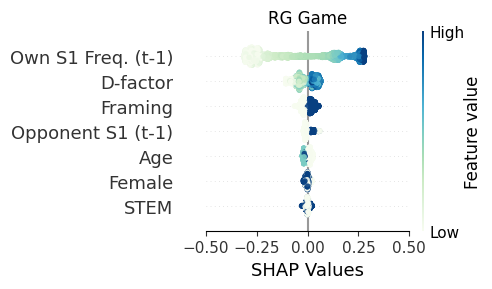

In [140]:
fig=plt.gcf()
shap.summary_plot(shap_values_g_tr[1], train_a[full_ind], plot_type="dot",
                  plot_size=(5,3), cmap ='GnBu' ,show=False, alpha=0.9)
plt.title("RG Game")
plt.xlabel("SHAP Values")
ax = plt.gca()

ax.set_xlim([-0.5, 0.5])

ax = plt.gca()
plt.tight_layout()
plt.show()

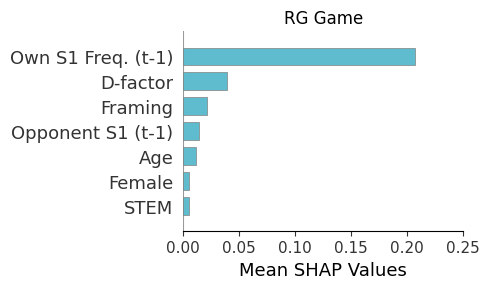

In [141]:
fig = plt.gcf()
shap.summary_plot(shap_values_g_tr[1], train_a[full_ind], plot_type="bar", color='#5EBCCE',
                  plot_size=(5,3), show=False)
plt.title("RG Game")
plt.xlabel("Mean SHAP Values")
ax = plt.gca()
for p in ax.patches:
    p.set_edgecolor('grey')
    p.set_linewidth(0.5) 
    
ax.set_xlim([0, 0.25])
plt.tight_layout()
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


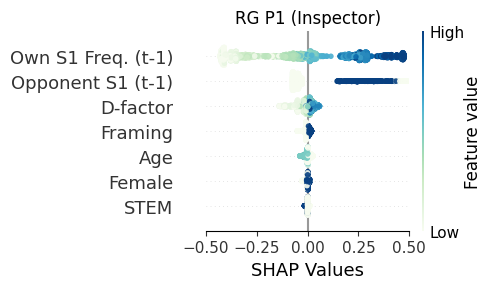

In [142]:

fig=plt.gcf()
shap.summary_plot(shap_values_p1_tr[1], train_p1[full_ind], plot_type="dot",
                  plot_size=(5,3), cmap ='GnBu' ,show=False, alpha=0.9)
plt.title("RG P1 (Inspector)")
plt.xlabel("SHAP Values")
ax = plt.gca()

ax.set_xlim([-0.5, 0.5])

ax = plt.gca()
plt.tight_layout()
plt.show()

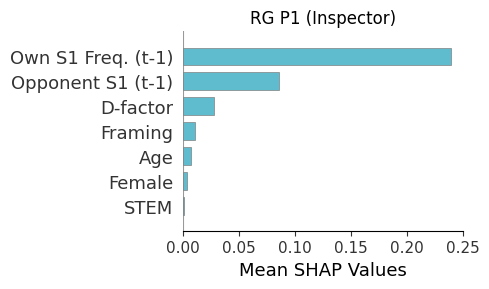

In [143]:
fig = plt.gcf()
shap.summary_plot(shap_values_p1_tr[1], train_p1[full_ind], plot_type="bar", color='#5EBCCE',
                  plot_size=(5,3), show=False)
plt.title("RG P1 (Inspector)")
plt.xlabel("Mean SHAP Values")
ax = plt.gca()
for p in ax.patches:
    p.set_edgecolor('grey')
    p.set_linewidth(0.5) 
    
ax.set_xlim([0, 0.25])
plt.tight_layout()
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


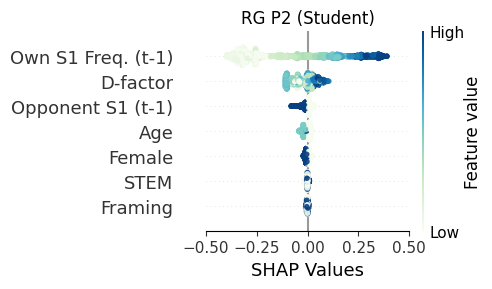

In [144]:
fig=plt.gcf()
shap.summary_plot(shap_values_p2_tr[1], train_p2[full_ind], plot_type="dot",
                  plot_size=(5,3), cmap ='GnBu' ,show=False, alpha=0.9)
plt.title("RG P2 (Student)")
plt.xlabel("SHAP Values")
ax = plt.gca()

ax.set_xlim([-0.5, 0.5])

ax = plt.gca()
plt.tight_layout()
plt.show()

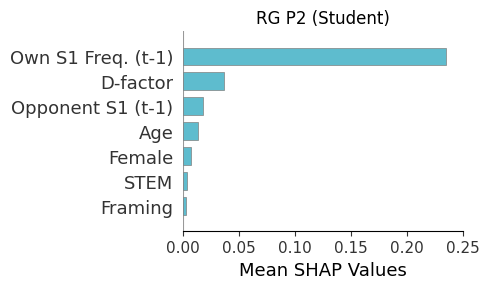

In [145]:
fig = plt.gcf()
shap.summary_plot(shap_values_p2_tr[1], train_p2[full_ind], plot_type="bar", color='#5EBCCE',
                  plot_size=(5,3), show=False)
plt.title("RG P2 (Student)")
plt.xlabel("Mean SHAP Values")
ax = plt.gca()
for p in ax.patches:
    p.set_edgecolor('grey')
    p.set_linewidth(0.5) 
    
ax.set_xlim([0, 0.25])
plt.tight_layout()
plt.show()

In [148]:
metrics_list = [metrics_all, metrics_p1, metrics_p2]
df_metrics = pd.DataFrame(metrics_list)
df_metrics.index = ['Game', 'Inspector', 'Student']
df_metrics

,mse,mae,rmse,cv_rmse_scores,f1,precision,recall,confusion_mat,accuracy
Game,0.215714,0.215714,0.464451,"[0.45118890563867875, 0.4183300132670378, 0.47...",0.663697,0.555970,0.823204,"[[800, 238], [64, 298]]",0.784286
Inspector,0.221429,0.221429,0.470562,"[0.49280538030458115, 0.47809144373375745, 0.4...",0.731369,0.727586,0.735192,"[[334, 79], [76, 211]]",0.778571
Student,0.351429,0.351429,0.592814,"[0.5, 0.541162769282166, 0.5209880722517277, 0...",0.690955,0.540275,0.958188,"[[179, 234], [12, 275]]",0.648571


In [149]:
importances_all = model_g.feature_importances_
importances_p1 = model_p1.feature_importances_
importances_p2 = model_p2.feature_importances_
feature_names = full_ind

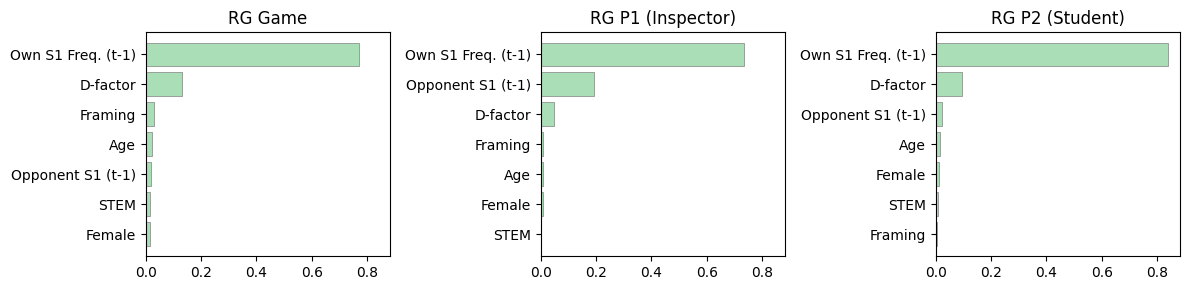

In [156]:
models = {
    "RG Game": model_g,
    "RG P1 (Inspector)": model_p1,
    "RG P2 (Student)": model_p2,
}
df_trains_dict = {
    "RG Game": train_a,
    "RG P1 (Inspector)": train_p1,
    "RG P2 (Student)": train_p2,
}
plot_feature_importances(df_trains_dict, full_ind, models, '#AADEB6')

In [158]:
roc_auc_rf_all, fpr_rf_all, tpr_rf_all = calculate_roc_auc(model_g, test_a, full_ind, dep)
roc_auc_rf_p1, fpr_rf_p1, tpr_rf_p1 = calculate_roc_auc(model_p1, test_p1, full_ind, dep)
roc_auc_rf_p2, fpr_rf_p2, tpr_rf_p2 = calculate_roc_auc(model_p2, test_p2, full_ind, dep)

print("Area Under the ROC Curve (model with more variables)")
print("AUC Game:", roc_auc_rf_all)
print("AUC P1:", roc_auc_rf_p1)
print("AUC P2:", roc_auc_rf_p2)

Area Under the ROC Curve (model with more variables)
AUC Game: 0.8826512417632719
AUC P1: 0.8746699175743053
AUC P2: 0.8244173182576737


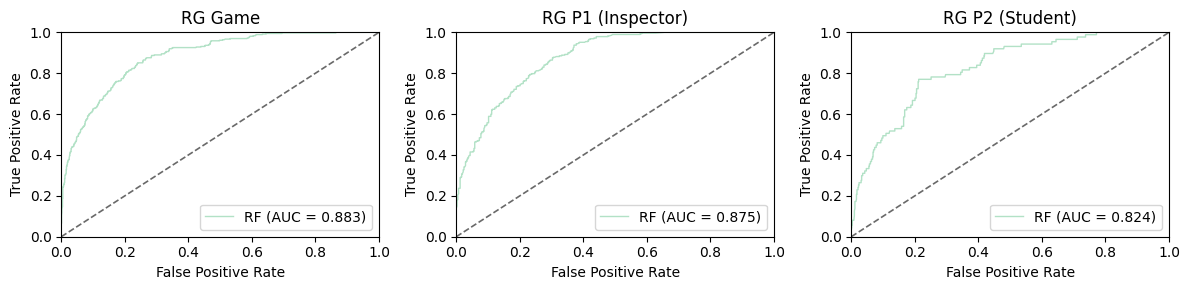

In [160]:
models_data = {
    "RG Game": (fpr_rf_all, tpr_rf_all, roc_auc_rf_all),
    "RG P1 (Inspector)": (fpr_rf_p1, tpr_rf_p1, roc_auc_rf_p1),
    "RG P2 (Student)": (fpr_rf_p2, tpr_rf_p2, roc_auc_rf_p2),
}
plot_roc_curves(models_data, '#9FDAB8')

## One-Shot Game Model

In [30]:
ntrials = 1000

In [31]:
%%time
params_g_os = optimize_rf(train_a_os, os_ind, dep, use_groups=False, ntrials= ntrials, resampler_type = 'none')

[I 2023-09-07 08:00:28,795] A new study created in memory with name: no-name-c6f30877-7341-410b-9a72-7dc2b8a271dc
[I 2023-09-07 08:01:06,215] Trial 8 finished with value: 0.4896025788417754 and parameters: {'n_estimators': 500, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 35, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 8 with value: 0.4896025788417754.
[I 2023-09-07 08:01:08,742] Trial 2 finished with value: 0.4914645747390726 and parameters: {'n_estimators': 600, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 50, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.4914645747390726.
[I 2023-09-07 08:01:11,972] Trial 11 finished with value: 0.49365185636031655 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 50, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 11 with value: 0.49

[I 2023-09-07 08:03:04,809] Trial 31 finished with value: 0.5146581456684927 and parameters: {'n_estimators': 700, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 27 with value: 0.5146581456684927.
[I 2023-09-07 08:03:09,571] Trial 32 finished with value: 0.5146581456684927 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 27 with value: 0.5146581456684927.
[I 2023-09-07 08:03:10,514] Trial 33 finished with value: 0.5146581456684927 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 27 with value: 0.5146581456684927.
[I 2023-09-07 08:03:11,667] Trial 24 finished with value: 0.486981582921936

[I 2023-09-07 08:04:31,688] Trial 54 finished with value: 0.5294132233267961 and parameters: {'n_estimators': 800, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 43 with value: 0.5294132233267961.
[I 2023-09-07 08:04:37,161] Trial 55 finished with value: 0.5294132233267961 and parameters: {'n_estimators': 800, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 43 with value: 0.5294132233267961.
[I 2023-09-07 08:04:40,530] Trial 56 finished with value: 0.5294132233267961 and parameters: {'n_estimators': 800, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 43 with value: 0.5294132233267961.
[I 2023-09-07 08:04:45,203] Trial 57 finished with value: 0.5294

[I 2023-09-07 08:06:20,777] Trial 86 finished with value: 0.49913482563512995 and parameters: {'n_estimators': 600, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 50, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 43 with value: 0.5294132233267961.
[I 2023-09-07 08:06:21,446] Trial 85 finished with value: 0.49009062013931154 and parameters: {'n_estimators': 600, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 50, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 43 with value: 0.5294132233267961.
[I 2023-09-07 08:06:24,941] Trial 78 finished with value: 0.5210565586889386 and parameters: {'n_estimators': 900, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 43 with value: 0.5294132233267961.
[I 2023-09-07 08:06:26,559] Trial 77 finished with value: 0.5055037082121683 and parameters: {'n_estimato

[I 2023-09-07 08:07:55,200] Trial 106 finished with value: 0.5294132233267961 and parameters: {'n_estimators': 800, 'max_depth': 25, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 43 with value: 0.5294132233267961.
[I 2023-09-07 08:08:05,603] Trial 109 finished with value: 0.5294132233267961 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 43 with value: 0.5294132233267961.
[I 2023-09-07 08:08:16,970] Trial 115 finished with value: 0.5229616104235703 and parameters: {'n_estimators': 700, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 43 with value: 0.5294132233267961.
[I 2023-09-07 08:08:17,058] Trial 114 finished with value: 0.5

[I 2023-09-07 08:09:29,430] Trial 136 finished with value: 0.5178839521201055 and parameters: {'n_estimators': 800, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 43 with value: 0.5294132233267961.
[I 2023-09-07 08:09:31,063] Trial 137 finished with value: 0.5178839521201055 and parameters: {'n_estimators': 800, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 43 with value: 0.5294132233267961.
[I 2023-09-07 08:09:33,595] Trial 138 finished with value: 0.5178839521201055 and parameters: {'n_estimators': 800, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 43 with value: 0.5294132233267961.
[I 2023-09-07 08:09:34,749] Trial 135 finished with value: 0.

[I 2023-09-07 08:11:10,126] Trial 158 finished with value: 0.492619868803679 and parameters: {'n_estimators': 900, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 20, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 43 with value: 0.5294132233267961.
[I 2023-09-07 08:11:14,193] Trial 165 finished with value: 0.5294132233267961 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 43 with value: 0.5294132233267961.
[I 2023-09-07 08:11:16,963] Trial 166 finished with value: 0.5294132233267961 and parameters: {'n_estimators': 800, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 43 with value: 0.5294132233267961.
[I 2023-09-07 08:11:18,390] Trial 160 finished with value: 0.50191406

[I 2023-09-07 08:13:00,829] Trial 190 finished with value: 0.5225030995694417 and parameters: {'n_estimators': 800, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 43 with value: 0.5294132233267961.
[I 2023-09-07 08:13:03,851] Trial 193 finished with value: 0.5225030995694417 and parameters: {'n_estimators': 800, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 43 with value: 0.5294132233267961.
[I 2023-09-07 08:13:08,510] Trial 194 finished with value: 0.5225030995694417 and parameters: {'n_estimators': 800, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 43 with value: 0.5294132233267961.
[I 2023-09-07 08:13:09,741] Trial 195 finished with value: 0.522503

[I 2023-09-07 08:14:37,672] Trial 218 finished with value: 0.515703207772593 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:14:38,454] Trial 215 finished with value: 0.5078230878474336 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 35, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:14:40,966] Trial 208 finished with value: 0.5281091499289917 and parameters: {'n_estimators': 1400, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:14:55,365] Trial 219 finished with value: 0.5157

[I 2023-09-07 08:16:28,889] Trial 242 finished with value: 0.5248833434773787 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:16:33,384] Trial 244 finished with value: 0.5248833434773787 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:16:36,131] Trial 246 finished with value: 0.5248833434773787 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:16:37,097] Trial 245 finished with value:

[I 2023-09-07 08:18:17,313] Trial 271 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:18:17,550] Trial 270 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:18:20,062] Trial 273 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:18:20,326] Trial 272 finished with value: 0.

[I 2023-09-07 08:20:12,064] Trial 296 finished with value: 0.5041646942133856 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:20:13,735] Trial 298 finished with value: 0.5041646942133856 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:20:22,754] Trial 293 finished with value: 0.4986091386578301 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:20:47,194] Trial 300 finished with value: 0.5113248123351593 and pa

[I 2023-09-07 08:22:10,433] Trial 325 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:22:11,711] Trial 324 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:22:13,026] Trial 326 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:22:13,260] Trial 328 finished with value: 0.

[I 2023-09-07 08:23:57,375] Trial 350 finished with value: 0.5243898920222719 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:23:58,607] Trial 351 finished with value: 0.5243898920222719 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:24:01,439] Trial 352 finished with value: 0.5243898920222719 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:24:04,350] Trial 353 finished with value: 0.

[I 2023-09-07 08:25:34,004] Trial 377 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:25:53,602] Trial 380 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:25:57,469] Trial 381 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:26:03,703] Trial 383 finished with value: 0.

[I 2023-09-07 08:27:25,577] Trial 405 finished with value: 0.5113248123351593 and parameters: {'n_estimators': 900, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:27:26,295] Trial 406 finished with value: 0.5113248123351593 and parameters: {'n_estimators': 900, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:27:28,254] Trial 407 finished with value: 0.5113248123351593 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:27:32,027] Trial 408 finished with value: 

[I 2023-09-07 08:29:16,636] Trial 432 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:29:19,574] Trial 433 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:29:22,840] Trial 434 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:29:28,119] Trial 435 finished with value: 0

[I 2023-09-07 08:31:01,661] Trial 459 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:31:11,724] Trial 460 finished with value: 0.515703207772593 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:31:15,633] Trial 461 finished with value: 0.515703207772593 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:31:16,459] Trial 464 finished with value: 0.529961

[I 2023-09-07 08:32:50,967] Trial 485 finished with value: 0.5248833434773787 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:32:52,306] Trial 484 finished with value: 0.5230159374225108 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:32:56,343] Trial 487 finished with value: 0.5248833434773787 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:32:58,827] Trial 489 finished with value:

[I 2023-09-07 08:35:06,042] Trial 515 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:35:07,237] Trial 514 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:35:10,525] Trial 516 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:35:12,738] Trial 512 finished with value: 0.

[I 2023-09-07 08:36:51,466] Trial 540 finished with value: 0.5113248123351593 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:37:03,111] Trial 542 finished with value: 0.5113248123351593 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:37:07,522] Trial 543 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:37:08,101] Trial 545 finished with value: 0.

[I 2023-09-07 08:38:25,200] Trial 565 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:38:28,359] Trial 569 finished with value: 0.5294132233267961 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:38:28,820] Trial 566 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:38:38,602] Trial 570 finished with value: 0.

[I 2023-09-07 08:40:12,729] Trial 596 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:40:12,965] Trial 595 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 25, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:40:16,874] Trial 594 finished with value: 0.5055037082121683 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 45, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:40:20,411] Trial 597 finished with value: 0

[I 2023-09-07 08:42:13,772] Trial 621 finished with value: 0.5248833434773787 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:42:16,931] Trial 623 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:42:17,149] Trial 624 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:42:19,175] Trial 625 finished with value: 0

[I 2023-09-07 08:43:57,688] Trial 644 finished with value: 0.49269245508442105 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 20, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:44:08,533] Trial 649 finished with value: 0.505573589414125 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:44:14,101] Trial 645 finished with value: 0.4908755438335476 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 25, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:44:16,518] Trial 651 finished with value: 0.4

[I 2023-09-07 08:45:59,182] Trial 675 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:46:06,353] Trial 676 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:46:12,987] Trial 677 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:46:14,750] Trial 678 finished with value: 0.

[I 2023-09-07 08:48:00,744] Trial 708 finished with value: 0.5294132233267961 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:48:01,756] Trial 710 finished with value: 0.5294132233267961 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:48:06,140] Trial 709 finished with value: 0.515703207772593 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:48:08,643] Trial 711 finished with value: 0.5299610017808

[I 2023-09-07 08:49:39,145] Trial 723 finished with value: 0.5235093888776177 and parameters: {'n_estimators': 1300, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:49:42,590] Trial 732 finished with value: 0.5243898920222719 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:49:48,543] Trial 728 finished with value: 0.52253804017042 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:49:51,878] Trial 729 finished with value: 0.

[I 2023-09-07 08:51:18,580] Trial 754 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:51:33,465] Trial 757 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:51:38,990] Trial 759 finished with value: 0.5248833434773787 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:51:39,414] Trial 758 finished with value: 0

[I 2023-09-07 08:53:25,147] Trial 785 finished with value: 0.5113248123351593 and parameters: {'n_estimators': 900, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:53:26,004] Trial 783 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:53:26,414] Trial 784 finished with value: 0.5113248123351593 and parameters: {'n_estimators': 900, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:53:28,297] Trial 786 finished with value: 

[I 2023-09-07 08:54:58,417] Trial 810 finished with value: 0.5294132233267961 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:54:59,852] Trial 811 finished with value: 0.5294132233267961 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:55:09,541] Trial 812 finished with value: 0.5294132233267961 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:55:10,180] Trial 813 finished with value: 0.

[I 2023-09-07 08:57:10,192] Trial 838 finished with value: 0.505573589414125 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:57:12,242] Trial 837 finished with value: 0.505573589414125 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:57:19,229] Trial 839 finished with value: 0.5232943351141769 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:57:24,046] Trial 841 finished with value: 0.5232943

[I 2023-09-07 08:59:00,516] Trial 864 finished with value: 0.5243898920222719 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:59:06,700] Trial 865 finished with value: 0.5243898920222719 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:59:07,748] Trial 866 finished with value: 0.5243898920222719 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 08:59:09,243] Trial 868 finished with value: 0.

[I 2023-09-07 09:00:45,481] Trial 890 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 09:00:49,908] Trial 891 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 09:00:53,592] Trial 893 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 09:01:04,558] Trial 895 finished with value: 0.5299610017808435 and

[I 2023-09-07 09:02:35,481] Trial 918 finished with value: 0.5289121074817971 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 09:02:44,920] Trial 920 finished with value: 0.5289121074817971 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 09:02:45,108] Trial 921 finished with value: 0.5289121074817971 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 09:02:50,172] Trial 919 finished with value: 0.52891

[I 2023-09-07 09:04:23,757] Trial 943 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 09:04:26,463] Trial 946 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 09:04:28,593] Trial 948 finished with value: 0.5299610017808435 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 09:04:30,072] Trial 947 finished with value: 0.

[I 2023-09-07 09:05:59,016] Trial 972 finished with value: 0.5243898920222719 and parameters: {'n_estimators': 900, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 09:06:13,537] Trial 973 finished with value: 0.5243898920222719 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 09:06:14,654] Trial 974 finished with value: 0.5243898920222719 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.
[I 2023-09-07 09:06:16,701] Trial 976 finished with value: 0

[I 2023-09-07 09:07:16,870] Trial 999 finished with value: 0.505573589414125 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 211 with value: 0.5299610017808435.


{'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}
CPU times: total: 9min 49s
Wall time: 1h 6min 48s


In [32]:
%%time
params_p1_os = optimize_rf(train_p1_os, os_ind, dep, use_groups=False, ntrials= ntrials, resampler_type = 'none')

[I 2023-09-07 09:07:16,889] A new study created in memory with name: no-name-2f81651c-576e-4cf3-a57c-b5c134b89a02
[I 2023-09-07 09:07:58,446] Trial 3 finished with value: 0.566084876222176 and parameters: {'n_estimators': 600, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 35, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 3 with value: 0.566084876222176.
[I 2023-09-07 09:07:58,739] Trial 7 finished with value: 0.5342417308092365 and parameters: {'n_estimators': 700, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 3 with value: 0.566084876222176.
[I 2023-09-07 09:07:59,258] Trial 10 finished with value: 0.4886686082795923 and parameters: {'n_estimators': 500, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 15, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 3 with value: 0.566

[I 2023-09-07 09:10:18,681] Trial 37 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 700, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:10:25,631] Trial 38 finished with value: 0.5847618057000207 and parameters: {'n_estimators': 700, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 45, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:10:41,367] Trial 31 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1500, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:10:45,086] Trial 32 finished with value: 0.5924890784272935 a

[I 2023-09-07 09:12:41,727] Trial 53 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1300, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:12:50,045] Trial 55 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1400, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:12:52,483] Trial 56 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1400, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:12:54,895] Trial 57 finished with value: 0.5924890784272935

[I 2023-09-07 09:15:00,584] Trial 89 finished with value: 0.543430413979613 and parameters: {'n_estimators': 500, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 40, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:15:01,403] Trial 80 finished with value: 0.5326211774495526 and parameters: {'n_estimators': 1100, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:15:04,584] Trial 91 finished with value: 0.562943623881839 and parameters: {'n_estimators': 500, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 40, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:15:08,642] Trial 81 finished with value: 0.5326211774495526 and parameters: {'n_estimators':

[I 2023-09-07 09:17:01,021] Trial 107 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1500, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:17:03,073] Trial 108 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1500, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:17:08,595] Trial 111 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1200, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:17:14,613] Trial 110 finished with value: 0.592

[I 2023-09-07 09:19:15,954] Trial 135 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 900, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:19:23,679] Trial 142 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 900, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:19:27,032] Trial 129 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1300, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:19:28,457] Trial 130 finished with value: 0.59248907842729

[I 2023-09-07 09:22:01,330] Trial 164 finished with value: 0.5510068649885583 and parameters: {'n_estimators': 1400, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:22:04,434] Trial 161 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1400, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:22:22,064] Trial 162 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1400, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:22:25,083] Trial 163 finished with value: 0.5924890784272

[I 2023-09-07 09:24:36,447] Trial 189 finished with value: 0.5055460786353235 and parameters: {'n_estimators': 1300, 'max_depth': 25, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:24:40,016] Trial 190 finished with value: 0.5055460786353235 and parameters: {'n_estimators': 1300, 'max_depth': 25, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:24:43,937] Trial 200 finished with value: 0.5847618057000207 and parameters: {'n_estimators': 600, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:24:45,611] Trial 191 finished with value: 0.505546078

[I 2023-09-07 09:26:55,279] Trial 217 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1400, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:26:56,678] Trial 216 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1400, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:26:57,695] Trial 218 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1400, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:26:59,197] Trial 219 finished with value: 0.592489078427

[I 2023-09-07 09:29:46,444] Trial 244 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1500, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:29:49,330] Trial 245 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1500, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:29:49,607] Trial 230 finished with value: 0.49732681506136894 and parameters: {'n_estimators': 1400, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 5, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:29:50,251] Trial 228 finished with value: 0.497326815061

[I 2023-09-07 09:32:04,514] Trial 270 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1400, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:32:07,549] Trial 271 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1400, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:32:32,189] Trial 272 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1400, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:32:45,014] Trial 273 finished with value: 0.521909714998

[I 2023-09-07 09:34:32,715] Trial 298 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1300, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:34:35,621] Trial 299 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1300, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:34:41,360] Trial 294 finished with value: 0.5406303307676306 and parameters: {'n_estimators': 1300, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 30, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:34:41,791] Trial 300 finished with value: 0.592489

[I 2023-09-07 09:37:05,478] Trial 326 finished with value: 0.41516642396505093 and parameters: {'n_estimators': 1400, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:37:09,185] Trial 329 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 600, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:37:10,667] Trial 332 finished with value: 0.5253089244851258 and parameters: {'n_estimators': 600, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:37:34,797] Trial 320 finished with value: 0.592489078427293

[I 2023-09-07 09:39:41,729] Trial 352 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1500, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:39:55,690] Trial 353 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1500, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:39:56,750] Trial 354 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1500, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:40:00,098] Trial 355 finished with value: 0.592489078427

[I 2023-09-07 09:42:29,468] Trial 379 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1400, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:42:31,094] Trial 382 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1400, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:42:32,677] Trial 381 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1400, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:42:35,723] Trial 383 finished with value: 0.592489078427

[I 2023-09-07 09:44:16,051] Trial 402 finished with value: 0.5219097149989598 and parameters: {'n_estimators': 1300, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:44:21,227] Trial 407 finished with value: 0.5219097149989598 and parameters: {'n_estimators': 900, 'max_depth': 25, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:44:41,316] Trial 406 finished with value: 0.5219097149989598 and parameters: {'n_estimators': 1300, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:44:45,230] Trial 411 finished with value: 0.5924890

[I 2023-09-07 09:46:54,574] Trial 432 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1300, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:47:00,968] Trial 433 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1400, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:47:11,249] Trial 434 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1400, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:47:14,604] Trial 435 finished with value: 0.592489078427

[I 2023-09-07 09:49:31,742] Trial 459 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1400, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:49:38,261] Trial 460 finished with value: 0.5847618057000207 and parameters: {'n_estimators': 1400, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:49:47,470] Trial 461 finished with value: 0.5847618057000207 and parameters: {'n_estimators': 1400, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:49:50,137] Trial 463 finished with value: 0.5847618057000207 and p

[I 2023-09-07 09:52:12,929] Trial 484 finished with value: 0.5510068649885583 and parameters: {'n_estimators': 1500, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:52:13,377] Trial 475 finished with value: 0.5774890784272936 and parameters: {'n_estimators': 1300, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 50, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:52:17,270] Trial 489 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 700, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:52:18,698] Trial 485 finished with value: 0.5510068649885

[I 2023-09-07 09:54:46,470] Trial 510 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1200, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:54:47,355] Trial 513 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1200, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:54:49,367] Trial 514 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1200, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:54:50,050] Trial 515 finished with value: 0.592489078427

[I 2023-09-07 09:57:29,684] Trial 542 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1400, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:57:33,343] Trial 543 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1400, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:57:33,679] Trial 544 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1400, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:57:38,618] Trial 545 finished with value: 0.592489078427

[I 2023-09-07 09:59:31,779] Trial 564 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1300, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:59:35,693] Trial 561 finished with value: 0.5406303307676306 and parameters: {'n_estimators': 1300, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 30, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:59:36,262] Trial 566 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1300, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 09:59:42,256] Trial 574 finished with value: 0.592489078427

[I 2023-09-07 10:02:12,626] Trial 595 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1300, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:02:16,585] Trial 594 finished with value: 0.5847618057000207 and parameters: {'n_estimators': 1300, 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 45, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:02:23,159] Trial 597 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1300, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:02:23,848] Trial 598 finished with value: 0.592489078427

[I 2023-09-07 10:04:35,287] Trial 620 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1400, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:04:44,092] Trial 619 finished with value: 0.543430413979613 and parameters: {'n_estimators': 1400, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 40, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:04:59,873] Trial 622 finished with value: 0.5847618057000207 and parameters: {'n_estimators': 1500, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:05:05,179] Trial 624 finished with value: 0.5924890

[I 2023-09-07 10:07:13,062] Trial 647 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1300, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:07:19,995] Trial 649 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1300, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:07:22,909] Trial 650 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1300, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:07:29,089] Trial 651 finished with value: 0.5055460786353235 and parameters:

[I 2023-09-07 10:09:57,666] Trial 677 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1400, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:10:05,784] Trial 678 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1400, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:10:07,901] Trial 679 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1400, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:10:18,027] Trial 680 finished with value: 0.592489078427

[I 2023-09-07 10:12:27,538] Trial 700 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1400, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:12:27,867] Trial 701 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1400, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:12:34,341] Trial 702 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1300, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:12:57,964] Trial 707 finished with value: 0.592489078427

[I 2023-09-07 10:14:38,132] Trial 725 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1300, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:15:06,812] Trial 727 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1300, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:15:08,980] Trial 730 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1300, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:15:10,009] Trial 729 finished with value: 0.592489078427

[I 2023-09-07 10:17:32,903] Trial 756 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1400, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:17:37,986] Trial 757 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1500, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:17:41,195] Trial 758 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1500, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:17:41,856] Trial 760 finished with value: 0.592489078427

[I 2023-09-07 10:20:01,698] Trial 783 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1300, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:20:06,281] Trial 791 finished with value: 0.5219097149989598 and parameters: {'n_estimators': 800, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:20:09,596] Trial 792 finished with value: 0.5219097149989598 and parameters: {'n_estimators': 800, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:20:14,557] Trial 785 finished with value: 0.5924890784

[I 2023-09-07 10:22:44,010] Trial 814 finished with value: 0.41516642396505093 and parameters: {'n_estimators': 1400, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:22:44,350] Trial 807 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1400, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:22:47,367] Trial 816 finished with value: 0.41516642396505093 and parameters: {'n_estimators': 1400, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:22:50,237] Trial 808 finished with value: 0.592489078

[I 2023-09-07 10:25:24,245] Trial 847 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 900, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:25:25,479] Trial 837 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1300, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:25:31,572] Trial 838 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1300, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:25:33,316] Trial 840 finished with value: 0.5924890784272

[I 2023-09-07 10:27:29,637] Trial 863 finished with value: 0.5847618057000207 and parameters: {'n_estimators': 1400, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:27:46,985] Trial 865 finished with value: 0.5847618057000207 and parameters: {'n_estimators': 1400, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:27:53,619] Trial 866 finished with value: 0.5847618057000207 and parameters: {'n_estimators': 1400, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:27:55,810] Trial 867 finished with value: 0.5847618057000207 and parameters: {'n_estim

[I 2023-09-07 10:30:22,182] Trial 891 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1500, 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:30:25,324] Trial 892 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1500, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:30:26,943] Trial 893 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1500, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:30:33,592] Trial 894 finished with value: 0.592489078427

[I 2023-09-07 10:32:36,353] Trial 917 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1300, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:32:46,436] Trial 919 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 900, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:32:56,797] Trial 923 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 900, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:33:19,068] Trial 920 finished with value: 0.59248907842729

[I 2023-09-07 10:36:03,618] Trial 937 finished with value: 0.566084876222176 and parameters: {'n_estimators': 1400, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 35, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:36:06,558] Trial 947 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1400, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:36:11,686] Trial 943 finished with value: 0.5243863116288746 and parameters: {'n_estimators': 1400, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 35, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:36:20,985] Trial 942 finished with value: 0.55021635115

[I 2023-09-07 10:38:18,981] Trial 969 finished with value: 0.5847618057000207 and parameters: {'n_estimators': 1300, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 45, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:38:23,225] Trial 973 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1300, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:38:32,047] Trial 974 finished with value: 0.5924890784272935 and parameters: {'n_estimators': 1300, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.
[I 2023-09-07 10:38:33,972] Trial 975 finished with value: 0.592489078427

[I 2023-09-07 10:40:08,759] Trial 995 finished with value: 0.5233451216975246 and parameters: {'n_estimators': 1200, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 20, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 25 with value: 0.5924890784272935.


{'n_estimators': 1400, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}
CPU times: total: 12min 50s
Wall time: 1h 32min 51s


In [33]:
%%time
params_p2_os = optimize_rf(train_p2_os, os_ind, dep, use_groups=False, ntrials= ntrials, resampler_type = 'none')

[I 2023-09-07 10:40:08,775] A new study created in memory with name: no-name-a97182c5-318c-41de-a39a-466a8c657dd7
[I 2023-09-07 10:40:33,417] Trial 15 finished with value: 0.5 and parameters: {'n_estimators': 1100, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 15 with value: 0.5.
[I 2023-09-07 10:41:05,718] Trial 12 finished with value: 0.6178571428571429 and parameters: {'n_estimators': 500, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 15, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 10:41:06,648] Trial 10 finished with value: 0.5601890756302521 and parameters: {'n_estimators': 700, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 35, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.


[I 2023-09-07 10:43:06,895] Trial 23 finished with value: 0.5675420168067227 and parameters: {'n_estimators': 1500, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 45, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 10:43:10,016] Trial 32 finished with value: 0.5891806722689076 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 10:43:10,900] Trial 28 finished with value: 0.5252100840336136 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 5, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 10:43:13,106] Trial 36 finished with value: 0.60976890756302

[I 2023-09-07 10:45:19,725] Trial 52 finished with value: 0.5704831932773109 and parameters: {'n_estimators': 1400, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 10:45:22,083] Trial 54 finished with value: 0.5704831932773109 and parameters: {'n_estimators': 1400, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 10:45:25,422] Trial 53 finished with value: 0.5704831932773109 and parameters: {'n_estimators': 1400, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 10:45:26,365] Trial 55 finished with value: 0.5704831932773109 and parameters

[I 2023-09-07 10:47:19,309] Trial 80 finished with value: 0.582563025210084 and parameters: {'n_estimators': 900, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 30, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 10:47:22,630] Trial 81 finished with value: 0.582563025210084 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 30, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 10:47:27,035] Trial 88 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 10:47:28,060] Trial 82 finished with value: 0.582563025210084 and par

[I 2023-09-07 10:49:28,927] Trial 115 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 700, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 10:49:30,323] Trial 116 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 700, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 10:49:32,797] Trial 117 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 700, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 10:49:33,285] Trial 118 finished with value: 0.609768

[I 2023-09-07 10:50:59,740] Trial 136 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 45, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 10:51:09,427] Trial 137 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 45, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 10:51:10,011] Trial 138 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 45, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 10:51:11,238] Trial 140 finished with value: 0.558298319

[I 2023-09-07 10:53:22,383] Trial 159 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 1500, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 10:53:22,519] Trial 169 finished with value: 0.5668067226890756 and parameters: {'n_estimators': 600, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 10:53:22,800] Trial 168 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 600, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 10:53:26,021] Trial 161 finished with value: 0.5697478991596

[I 2023-09-07 10:56:25,002] Trial 189 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 1400, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 10:56:25,994] Trial 190 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 1400, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 10:56:29,665] Trial 191 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 1400, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 10:56:29,792] Trial 192 finished with value: 0.609

[I 2023-09-07 10:58:28,477] Trial 221 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 1300, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 10:58:30,944] Trial 226 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 10:58:32,647] Trial 228 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 10:58:34,737] Trial 222 finished with value: 0.6097689075630252 and parameters: {'n_esti

[I 2023-09-07 11:00:14,651] Trial 248 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 900, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:00:18,597] Trial 249 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 900, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:00:19,563] Trial 245 finished with value: 0.5472689075630253 and parameters: {'n_estimators': 900, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 35, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:00:20,015] Trial 250 finished with value: 0.609768907563025

[I 2023-09-07 11:01:39,956] Trial 272 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 800, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:01:48,085] Trial 273 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 800, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:01:51,997] Trial 280 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 600, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:01:53,676] Trial 274 finished with value: 0.6097689

[I 2023-09-07 11:03:01,849] Trial 298 finished with value: 0.5734243697478991 and parameters: {'n_estimators': 700, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:03:04,340] Trial 300 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 600, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:03:05,149] Trial 303 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 500, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:03:06,101] Trial 302 finished with value: 0.6097

[I 2023-09-07 11:05:29,840] Trial 330 finished with value: 0.5453781512605043 and parameters: {'n_estimators': 1500, 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:05:30,035] Trial 331 finished with value: 0.5453781512605043 and parameters: {'n_estimators': 1400, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:05:33,100] Trial 333 finished with value: 0.5453781512605043 and parameters: {'n_estimators': 1400, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:05:37,179] Trial 318 finished with value: 0.60976890

[I 2023-09-07 11:08:15,236] Trial 360 finished with value: 0.5697478991596638 and parameters: {'n_estimators': 900, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:08:15,546] Trial 359 finished with value: 0.5697478991596638 and parameters: {'n_estimators': 900, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:08:20,804] Trial 361 finished with value: 0.5697478991596638 and parameters: {'n_estimators': 900, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:08:26,910] Trial 364 finished with value: 0.

[I 2023-09-07 11:09:53,821] Trial 384 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:10:03,729] Trial 388 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:10:04,012] Trial 380 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 1200, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:10:06,139] Trial 381 finished with value: 0.6097689075630252 

[I 2023-09-07 11:11:33,504] Trial 409 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:11:35,257] Trial 410 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 900, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:11:39,703] Trial 412 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 900, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:11:42,477] Trial 411 finished with value: 0.6097689075630252

[I 2023-09-07 11:13:52,692] Trial 433 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 1400, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:13:58,438] Trial 442 finished with value: 0.5697478991596638 and parameters: {'n_estimators': 800, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:14:15,474] Trial 436 finished with value: 0.5704831932773109 and parameters: {'n_estimators': 1400, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:14:16,282] Trial 434 finished with value: 0.

[I 2023-09-07 11:15:58,136] Trial 466 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:16:01,576] Trial 468 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 800, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:16:04,364] Trial 469 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 800, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:16:05,347] Trial 462 finished with value: 0.6097689

[I 2023-09-07 11:17:39,153] Trial 467 finished with value: 0.5667016806722689 and parameters: {'n_estimators': 1500, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 25, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:18:00,272] Trial 486 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 1500, 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:18:06,917] Trial 498 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 900, 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:18:09,332] Trial 500 finished with value: 0.6097689075630252 a

[I 2023-09-07 11:19:41,843] Trial 512 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 1100, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:19:54,059] Trial 522 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 700, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:19:56,081] Trial 510 finished with value: 0.558298319327731 and parameters: {'n_estimators': 1100, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 40, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:19:57,711] Trial 524 finished with value: 0.6097689075630

[I 2023-09-07 11:21:58,289] Trial 544 finished with value: 0.5697478991596638 and parameters: {'n_estimators': 1400, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:22:07,545] Trial 548 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:22:10,007] Trial 549 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:22:24,020] Trial 551 finished with value: 0.60976

[I 2023-09-07 11:23:56,400] Trial 570 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:23:58,243] Trial 572 finished with value: 0.5697478991596638 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:23:59,235] Trial 571 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 900, 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:24:03,878] Trial 575 finished with value: 0.569747

[I 2023-09-07 11:25:03,441] Trial 598 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 700, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:25:11,211] Trial 600 finished with value: 0.5472689075630253 and parameters: {'n_estimators': 600, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 35, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:25:14,579] Trial 605 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 600, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:25:20,101] Trial 604 finished with value: 0.609768907563025

[I 2023-09-07 11:27:09,748] Trial 618 finished with value: 0.5868697478991596 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 20, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:27:09,927] Trial 616 finished with value: 0.5868697478991596 and parameters: {'n_estimators': 1300, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 20, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:27:16,400] Trial 617 finished with value: 0.5868697478991596 and parameters: {'n_estimators': 1300, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 20, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:27:36,036] Trial 628 finished with value: 0.5868697478991596

[I 2023-09-07 11:29:33,128] Trial 650 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 1400, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:29:33,352] Trial 651 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 1400, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:29:34,504] Trial 659 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 700, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:29:35,792] Trial 636 finished with value: 0.5868

[I 2023-09-07 11:32:07,098] Trial 684 finished with value: 0.6027310924369748 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:32:07,308] Trial 685 finished with value: 0.6027310924369748 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:32:14,101] Trial 686 finished with value: 0.6027310924369748 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:32:14,703] Trial 682 finished with value: 0.609768907563025

[I 2023-09-07 11:33:52,764] Trial 709 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 900, 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:33:53,081] Trial 708 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 900, 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:34:10,244] Trial 711 finished with value: 0.5697478991596638 and parameters: {'n_estimators': 900, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:34:34,397] Trial 713 finished with value: 0.5697478991596638 and parameters: {

[I 2023-09-07 11:35:31,258] Trial 740 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 600, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:35:32,415] Trial 741 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 600, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:35:38,010] Trial 742 finished with value: 0.5726890756302521 and parameters: {'n_estimators': 600, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:35:38,630] Trial 729 finished with value: 0.6097689075

[I 2023-09-07 11:37:45,950] Trial 766 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 800, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:37:50,307] Trial 768 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 800, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:37:53,801] Trial 769 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 800, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:38:01,610] Trial 770 finished with value: 0.609768

[I 2023-09-07 11:39:29,413] Trial 784 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 1200, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:39:33,818] Trial 782 finished with value: 0.5472689075630253 and parameters: {'n_estimators': 1100, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 35, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:39:34,145] Trial 798 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 500, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:39:44,563] Trial 790 finished with value: 0.5207983193277311 and par

[I 2023-09-07 11:41:38,483] Trial 814 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 1300, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:41:58,387] Trial 817 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 1300, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:42:03,239] Trial 823 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 900, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:42:04,802] Trial 826 finished with value: 0.6097689

[I 2023-09-07 11:43:04,806] Trial 844 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 800, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:43:05,639] Trial 843 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 800, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:43:10,831] Trial 845 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 800, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:43:19,632] Trial 846 finished with value: 0.609768907563025

[I 2023-09-07 11:45:33,244] Trial 873 finished with value: 0.6009453781512605 and parameters: {'n_estimators': 1400, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 50, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:45:33,701] Trial 868 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 1400, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:45:35,667] Trial 874 finished with value: 0.6009453781512605 and parameters: {'n_estimators': 1400, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 50, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:45:36,301] Trial 869 finished with value: 0.6097689075630252 and parameters: {'n_

[I 2023-09-07 11:47:18,543] Trial 896 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 900, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:47:29,881] Trial 897 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 900, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:47:46,508] Trial 911 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 500, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:47:55,378] Trial 898 finished with value: 0.609768

[I 2023-09-07 11:49:48,332] Trial 922 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 1500, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:49:50,522] Trial 923 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 1500, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:49:51,930] Trial 924 finished with value: 0.5726890756302521 and parameters: {'n_estimators': 1500, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:49:53,388] Trial 934 finished with value: 0.6

[I 2023-09-07 11:51:18,851] Trial 950 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:51:22,218] Trial 952 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:51:25,863] Trial 953 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 800, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:51:26,504] Trial 958 finished with value: 0.6097689075630252 and parameters: {'n_es

[I 2023-09-07 11:53:38,040] Trial 983 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 1000, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 50, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:53:38,600] Trial 966 finished with value: 0.5891806722689076 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:53:39,627] Trial 979 finished with value: 0.6097689075630252 and parameters: {'n_estimators': 1400, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 55, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 12 with value: 0.6178571428571429.
[I 2023-09-07 11:53:44,601] Trial 969 finished with value: 0.54474789915966

{'n_estimators': 500, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 15, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}
CPU times: total: 10min 4s
Wall time: 1h 14min 35s


In [16]:
params_g_os = {'n_estimators': 900, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 55, 
               'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}

params_p1_os = {'n_estimators': 1400, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 60, 
                'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}


params_p2_os = {'n_estimators': 500, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 15, 
                'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}

In [17]:
%%time
model_g_os, y_pred_g_os, pipeline_g_os = fit_random_forest(train_a_os, test_a_os, os_ind, 's1', params_g_os)
metrics_all_os = calculate_metrics(test_a_os, os_ind, 's1', model_g_os)

model_p1_os, y_pred_p1_os,pipeline_p1_os = fit_random_forest(train_p1_os, test_p1_os, os_ind, 's1', params_p1_os)
metrics_p1_os = calculate_metrics(test_p1_os, os_ind, 's1', model_p1_os)

model_p2_os, y_pred_p2_os, pipeline_p2_os = fit_random_forest(train_p2_os, test_p2_os, os_ind, 's1', params_p2_os)
metrics_p2_os = calculate_metrics(test_p2_os, os_ind, 's1', model_p2_os)

CPU times: user 52.5 s, sys: 684 ms, total: 53.1 s
Wall time: 58.8 s


In [17]:
explainer_g_os = shap.TreeExplainer(model_g_os)
explainer_p1_os = shap.TreeExplainer(model_p1_os)
explainer_p2_os = shap.TreeExplainer(model_p2_os)

In [18]:
# training set shap values 
shap_values_g_tr_os = explainer_g_os.shap_values(train_a_os[os_ind])
shap_values_p1_tr_os = explainer_p1_os.shap_values(train_p1_os[os_ind])
shap_values_p2_tr_os = explainer_p2_os.shap_values(train_p2_os[os_ind])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


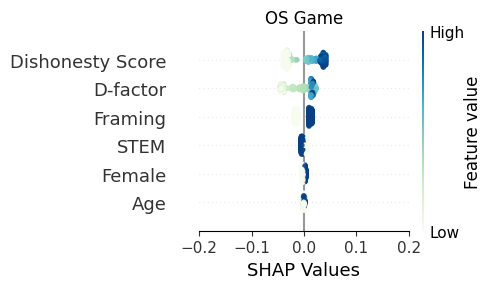

In [178]:
fig=plt.gcf()
shap.summary_plot(shap_values_g_tr_os[1], train_a_os[os_ind], plot_type="dot",
                  plot_size=(5,3), cmap ='GnBu' ,show=False, alpha=0.9)
plt.title("OS Game")
plt.xlabel("SHAP Values")
ax = plt.gca()

ax.set_xlim([-0.2, 0.2])

ax = plt.gca()
plt.tight_layout()
plt.show()

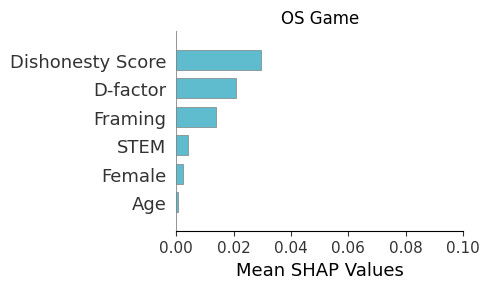

In [179]:


fig = plt.gcf()
shap.summary_plot(shap_values_g_tr_os[1], train_a_os[os_ind], plot_type="bar", color='#5EBCCE',
                  plot_size=(5,3), show=False)
plt.title("OS Game")
plt.xlabel("Mean SHAP Values")
ax = plt.gca()
for p in ax.patches:
    p.set_edgecolor('grey')
    p.set_linewidth(0.5) 
    
ax.set_xlim([0, 0.1])
plt.tight_layout()
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


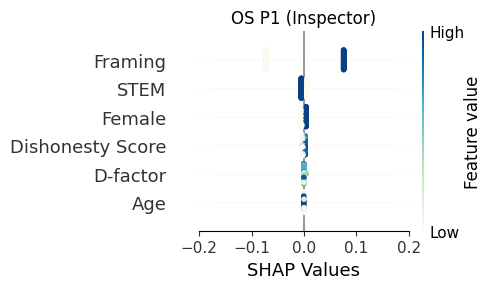

In [180]:
fig=plt.gcf()
shap.summary_plot(shap_values_p1_tr_os[1], train_p1_os[os_ind], plot_type="dot",
                  plot_size=(5,3), cmap ='GnBu' ,show=False, alpha=0.9)
plt.title("OS P1 (Inspector)")
plt.xlabel("SHAP Values")
ax = plt.gca()

ax.set_xlim([-0.2, 0.2])

ax = plt.gca()
plt.tight_layout()
plt.show()

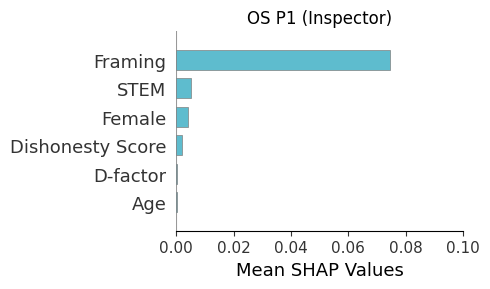

In [181]:
fig = plt.gcf()
shap.summary_plot(shap_values_p1_tr_os[1], train_p1_os[os_ind], plot_type="bar", color='#5EBCCE',
                  plot_size=(5,3), show=False)
plt.title("OS P1 (Inspector)")
plt.xlabel("Mean SHAP Values")
ax = plt.gca()
for p in ax.patches:
    p.set_edgecolor('grey')
    p.set_linewidth(0.5) 
    
ax.set_xlim([0, 0.1])
plt.tight_layout()
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


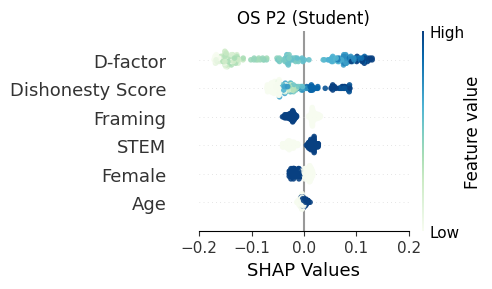

In [182]:
fig=plt.gcf()
shap.summary_plot(shap_values_p2_tr_os[1], train_p2_os[os_ind], plot_type="dot",
                  plot_size=(5,3), cmap ='GnBu' ,show=False, alpha=0.9)
plt.title("OS P2 (Student)")
plt.xlabel("SHAP Values")
ax = plt.gca()

ax.set_xlim([-0.2, 0.2])

ax = plt.gca()
plt.tight_layout()
plt.show()

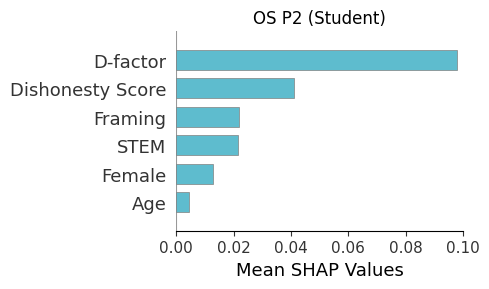

In [183]:
fig = plt.gcf()
shap.summary_plot(shap_values_p2_tr_os[1], train_p2_os[os_ind], plot_type="bar", color='#5EBCCE',
                  plot_size=(5,3), show=False)
plt.title("OS P2 (Student)")
plt.xlabel("Mean SHAP Values")
ax = plt.gca()
for p in ax.patches:
    p.set_edgecolor('grey')
    p.set_linewidth(0.5) 
    
ax.set_xlim([0, 0.1])
plt.tight_layout()
plt.show()

In [163]:
metrics_list_os = [metrics_all_os, metrics_p1_os, metrics_p2_os]
df_metrics_os = pd.DataFrame(metrics_list_os)
df_metrics_os.index = ['Game', 'Inspector', 'Student']
df_metrics_os

,mse,mae,rmse,cv_rmse_scores,f1,precision,recall,confusion_mat,accuracy
Game,0.500000,0.500000,0.707107,"[0.6396021490668313, 0.6172133998483676, 0.617...",0.430108,0.400000,0.465116,"[[33, 30], [23, 20]]",0.500000
Inspector,0.415094,0.415094,0.644278,"[0.7977240352174656, 0.7977240352174656, 0.797...",0.656250,0.724138,0.600000,"[[10, 8], [14, 21]]",0.584906
Student,0.339623,0.339623,0.582772,"[0.6030226891555273, 0.6030226891555273, 0.674...",0.250000,0.200000,0.333333,"[[32, 12], [6, 3]]",0.660377


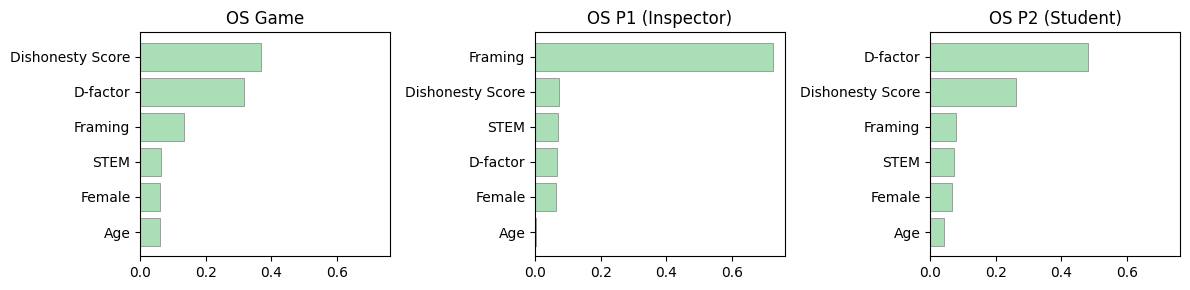

In [164]:
models = {
    "OS Game": model_g_os,
    "OS P1 (Inspector)": model_p1_os,
    "OS P2 (Student)": model_p2_os,
}
df_trains_dict_i = {
    "OS Game": train_a_os,
    "OS P1 (Inspector)": train_p1_os,
    "OS P2 (Student)": train_p2_os,
}
plot_feature_importances(df_trains_dict_i, os_ind, models, '#AADEB6')

In [166]:
roc_auc_rf_all_os, fpr_rf_all_os, tpr_rf_all_os = calculate_roc_auc(model_g_os, test_a_os, os_ind, dep)
roc_auc_rf_p1_os, fpr_rf_p1_os, tpr_rf_p1_os = calculate_roc_auc(model_p1_os, test_p1_os, os_ind, dep)
roc_auc_rf_p2_os, fpr_rf_p2_os, tpr_rf_p2_os = calculate_roc_auc(model_p2_os, test_p2_os, os_ind, dep)

print("Area Under the ROC Curve (model with more variables)")
print("AUC Game:", roc_auc_rf_all_os)
print("AUC P1:", roc_auc_rf_p1_os)
print("AUC P2:", roc_auc_rf_p2_os)

Area Under the ROC Curve (model with more variables)
AUC Game: 0.4808047249907715
AUC P1: 0.55
AUC P2: 0.5959595959595959


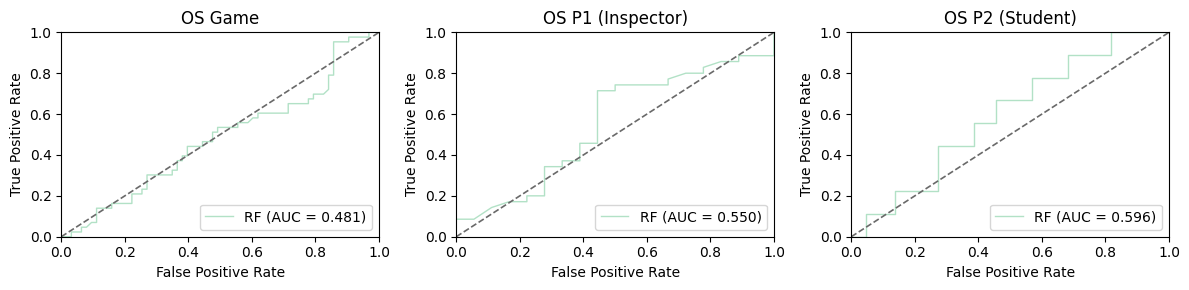

In [167]:
models_data = {
    "OS Game": (fpr_rf_all_os, tpr_rf_all_os, roc_auc_rf_all_os),
    "OS P1 (Inspector)": (fpr_rf_p1_os, tpr_rf_p1_os, roc_auc_rf_p1_os),
    "OS P2 (Student)": (fpr_rf_p2_os, tpr_rf_p2_os, roc_auc_rf_p2_os),
}
plot_roc_curves(models_data, '#9FDAB8')